# Imports 

In [1]:
## Essential Imports: 
import os
import numpy as np
import qp
import tables_io
from pathlib import Path 
from pzflow.examples import get_galaxy_data
import ceci

## RAIL-Specific Imports: 
import rail


import rail.creation 
import rail.creation.engines
from rail.creation.engines.flowEngine import FlowModeler, FlowCreator, FlowPosterior
from rail.core.data import TableHandle
from rail.core.stage import RailStage

from rail.estimation.algos.train_z import TrainZEstimator, TrainZInformer
from rail.estimation.algos.pzflow_nf import PZFlowInformer, PZFlowEstimator   


from rail.evaluation.evaluator import Evaluator


## Data Storage: 
DS = RailStage.data_store
DS.__class__.allow_overwrite = True


### CMNN, PZFlow, FlexZBoost, GPZ, trainz for control

In [2]:
## these don't work in rail_6-4-24, but they do in rail---new


from rail.creation.degradation.lsst_error_model import LSSTErrorModel
from rail.creation.degradation.spectroscopic_degraders import InvRedshiftIncompleteness
from rail.creation.degradation.quantityCut import QuantityCut 
from rail.core.utilStages import ColumnMapper, TableConverter
from rail.estimation.algos.cmnn import Inform_CMNNPDF, CMNNPDF
from rail.estimation.algos.gpz import GPzInformer, GPzEstimator 
from rail.estimation.algos.flexzboost import FlexZBoostInformer, FlexZBoostEstimator  

In [2]:
#from rail.stages import *
#rail.stages.import_and_attach_all()
#for val in RailStage.pipeline_stages.values():
#    print(val[0])

In [25]:
import numpy as np

def removeNans(df): 
    lsu = df.index[np.isnan(df['mag_u_lsst']) ==True].tolist() 
    lsg = df.index[np.isnan(df['mag_g_lsst']) ==True].tolist() 
    lsr = df.index[np.isnan(df['mag_r_lsst']) ==True].tolist() 
    lsi = df.index[np.isnan(df['mag_i_lsst']) ==True].tolist() 
    lsz = df.index[np.isnan(df['mag_z_lsst']) ==True].tolist() 
    lsy = df.index[np.isnan(df['mag_y_lsst']) ==True].tolist() 

    nans = list(set(lsu+lsg+lsr+lsi+lsz+lsy))
    new_df = df.drop(nans)

    return new_df 

In [20]:
def magCut(df, mag):
    lsu = df.index[df['mag_u_lsst'] > mag].tolist() 
    lsg = df.index[df['mag_g_lsst'] > mag].tolist() 
    lsr = df.index[df['mag_r_lsst'] > mag].tolist() 
    lsi = df.index[df['mag_i_lsst'] > mag].tolist() 
    lsz = df.index[df['mag_z_lsst'] > mag].tolist() 
    lsy = df.index[df['mag_y_lsst'] > mag].tolist() 

    cuts = list(set(lsu+lsg+lsr+lsi+lsz+lsy))
    new_df = df.drop(cuts)

    return new_df 

In [21]:
def nansList(df): 
    lsu = df.index[np.isnan(df['mag_u_lsst']) ==True].tolist() 
    lsg = df.index[np.isnan(df['mag_g_lsst']) ==True].tolist() 
    lsr = df.index[np.isnan(df['mag_r_lsst']) ==True].tolist() 
    lsi = df.index[np.isnan(df['mag_i_lsst']) ==True].tolist() 
    lsz = df.index[np.isnan(df['mag_z_lsst']) ==True].tolist() 
    lsy = df.index[np.isnan(df['mag_y_lsst']) ==True].tolist() 

    nans = list(set(lsu+lsg+lsr+lsi+lsz+lsy))

    return nans

# Model

In [77]:
# import pandas as pd 
# simpath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/rubin_roman_cat_galaxy_10307.parquet"
# simdf = pd.read_parquet(simpath)
# simdf


In [3]:
# zero_point_dict ={"u":12.627880975839947,"g":14.486360566315488,
# "r":14.324886825965237,"i":13.998598224053055,
# "z":13.612736383992512,"y":12.785119907991263}

# def flux_to_mag(flux, band):
#     zero = zero_point_dict[band]
#     return zero - 2.5*np.log10(flux)

In [4]:
# u_band_flux = flux_to_mag(simdf['lsst_flux_u'], 'u')
# g_band_flux = flux_to_mag(simdf['lsst_flux_g'], 'g')
# r_band_flux = flux_to_mag(simdf['lsst_flux_r'], 'r')
# i_band_flux = flux_to_mag(simdf['lsst_flux_i'], 'i')
# z_band_flux = flux_to_mag(simdf['lsst_flux_z'], 'z')
# y_band_flux = flux_to_mag(simdf['lsst_flux_y'], 'y')

In [97]:
# simdf.insert(10, "mag_u_lsst", u_band_flux, True)
# simdf.insert(11, "mag_g_lsst", g_band_flux, True)
# simdf.insert(12, "mag_r_lsst", r_band_flux, True)
# simdf.insert(13, "mag_i_lsst", i_band_flux, True)
# simdf.insert(14, "mag_z_lsst", z_band_flux, True)
# simdf.insert(15, "mag_y_lsst", y_band_flux, True)
# simdf

In [6]:
# sim_outpath = sim_outpath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/rubin_roman_catalog.pq"
# simdf.to_parquet(sim_outpath)

In [79]:
import pandas as pd
trimdf = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trimmed_rubin_roman_catalog.pq")
simdf = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/rubin_roman_catalog.pq")

In [87]:
indls = trimdf.index.tolist()

In [84]:
ibanddf

galaxy_id         ra        dec  redshift  lsst_flux_u  \
3        10307000647978  10.457563 -43.269365  0.985956     0.000014   
5        10307000647980  10.912042 -43.582034  0.985913     0.000011   
9        10307000647985  11.011674 -42.250945  0.992336     0.000011   
17       10307000647994   9.852447 -44.193237  0.989611     0.000010   
18       10307000647995   9.792334 -44.042291  0.983434     0.000013   
...                 ...        ...        ...       ...          ...   
3561728  10307200155493  10.787656 -43.005887  2.014481     0.000012   
3561750  10307200155521  10.011343 -42.713751  1.977320     0.000036   
3561785  10307200155567  10.715058 -43.305475  1.981840     0.000014   
3561842  10307200155643   8.961554 -44.329494  1.991436     0.000017   
3561861  10307200155666  10.227299 -43.435017  2.019502     0.000014   

         lsst_flux_g  lsst_flux_r  lsst_flux_i  lsst_flux_z  lsst_flux_y  \
3           0.000104     0.000150     0.000229     0.000276     0.000171   
5           0.000056     0.000053     0.000056     0.000055     0.000031   
9           0.000085     0.000202     0.000418     0.000640     0.000385   
17          0.000054     0.000056     0.000065     0.000070     0.000041   
18          0.000065     0.000060     0.000062     0.000058     0.000032   
...              ...          ...          ...          ...          ...   
3561728     0.000053     0.000045     0.000030     0.000022     0.000011   
3561750     0.000200     0.000211     0.000164     0.000138     0.000077   
3561785     0.000058     0.000050     0.000034     0.000025     0.000012   
3561842     0.000073     0.000063     0.000042     0.000031     0.000015   
3561861     0.000060     0.000052     0.000035     0.000025     0.000012   

         mag_u_lsst  mag_g_lsst  mag_r_lsst  mag_i_lsst  mag_z_lsst  \
3         24.761694   24.448673   23.882889   23.096676   22.509148   
5         25.027615   25.112160   25.014904   24.620735   24.265472   
9         25.064514   24.659109   23.559191   22.446104   21.597576   
17        25.097343   25.147274   24.960751   24.459522   23.996777   
18        24.866608   24.958704   24.882000   24.523258   24.206375   
...             ...         ...         ...         ...         ...   
3561728   24.904221   25.185871   25.182388   25.291752   25.256516   
3561750   23.749462   23.736328   23.511871   23.460197   23.260315   
3561785   24.786680   25.073315   25.072655   25.176960   25.122723   
3561842   24.527630   24.824486   24.828468   24.936996   24.894474   
3561861   24.746304   25.044044   25.039104   25.146473   25.109066   

         mag_y_lsst  
3         22.201382  
5         24.067717  
9         21.321320  
17        23.751797  
18        24.010294  
...             ...  
3561728   25.194820  
3561750   23.064390  
3561785   25.051857  
3561842   24.833225  
3561861   25.042957  

[269126 rows x 16 columns]

In [85]:
ibanddf = magCut(simdf, 25.3)
ibandinds = ibanddf.index.tolist()

# importing random module
import random
# getting numbers from 0 to 100
inputNumbers = ibandinds
# printing 4 random numbers from the given range of numbers which are
# non-repeating using sample() function
print("non-repeating random numbers are:")
rands = list(set(random.sample(inputNumbers, 169126)))
iband_cut_df = ibanddf.drop(rands)

non-repeating random numbers are:


In [86]:
iband_cut_df

galaxy_id         ra        dec  redshift  lsst_flux_u  \
17       10307000647994   9.852447 -44.193237  0.989611     0.000010   
61       10307000648047  10.239872 -42.521007  0.971248     0.000041   
68       10307000648058  10.743825 -42.747424  0.978290     0.000022   
70       10307000648060  10.739569 -42.745789  0.978568     0.000041   
89       10307000648085  10.939630 -42.993659  0.959503     0.000018   
...                 ...        ...        ...       ...          ...   
3561520  10307200155207  11.088073 -43.316896  1.999746     0.000016   
3561621  10307200155347   9.504255 -44.010729  2.015216     0.000013   
3561671  10307200155412   9.721232 -44.494606  2.007585     0.000023   
3561728  10307200155493  10.787656 -43.005887  2.014481     0.000012   
3561785  10307200155567  10.715058 -43.305475  1.981840     0.000014   

         lsst_flux_g  lsst_flux_r  lsst_flux_i  lsst_flux_z  lsst_flux_y  \
17          0.000054     0.000056     0.000065     0.000070     0.000041   
61          0.000281     0.000369     0.000516     0.000577     0.000357   
68          0.000112     0.000109     0.000119     0.000116     0.000068   
70          0.000265     0.000369     0.000587     0.000733     0.000426   
89          0.000094     0.000090     0.000099     0.000096     0.000054   
...              ...          ...          ...          ...          ...   
3561520     0.000066     0.000057     0.000038     0.000028     0.000014   
3561621     0.000054     0.000047     0.000032     0.000024     0.000012   
3561671     0.000149     0.000171     0.000139     0.000120     0.000068   
3561728     0.000053     0.000045     0.000030     0.000022     0.000011   
3561785     0.000058     0.000050     0.000034     0.000025     0.000012   

         mag_u_lsst  mag_g_lsst  mag_r_lsst  mag_i_lsst  mag_z_lsst  \
17        25.097343   25.147274   24.960751   24.459522   23.996777   
61        23.591553   23.362751   22.908192   22.217775   21.709229   
68        24.287392   24.359222   24.229897   23.811594   23.447582   
70        23.595581   23.429489   22.908447   22.077667   21.449455   
89        24.470921   24.556957   24.436068   24.008730   23.661484   
...             ...         ...         ...         ...         ...   
3561520   24.651722   24.945351   24.937542   25.038857   24.985132   
3561621   24.851715   25.146252   25.133617   25.234241   25.183479   
3561671   24.220465   24.054039   23.740200   23.638105   23.417171   
3561728   24.904221   25.185871   25.182388   25.291752   25.256516   
3561785   24.786680   25.073315   25.072655   25.176960   25.122723   

         mag_y_lsst  
17        23.751797  
61        21.403090  
68        23.209536  
70        21.212357  
89        23.445543  
...             ...  
3561520   24.908428  
3561621   25.104057  
3561671   23.200771  
3561728   25.194820  
3561785   25.051857  

[100000 rows x 16 columns]

In [88]:
iband_outpath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/1e6_i<25.3_rubin_roman_catalog.pq"
iband_cut_df.to_parquet(iband_outpath)

non-repeating random numbers are:


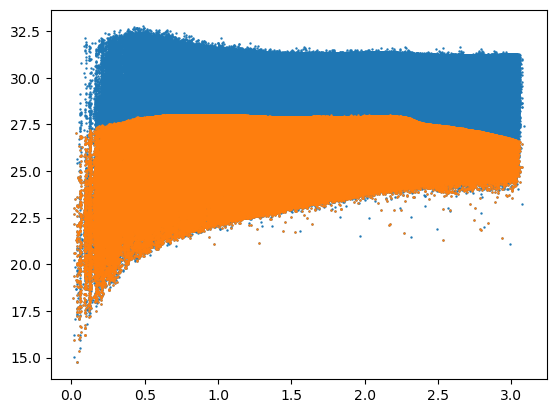

In [91]:
import numpy as np

# importing random module
import random
# getting numbers from 0 to 100
inputNumbers = indls
# printing 4 random numbers from the given range of numbers which are
# non-repeating using sample() function
print("non-repeating random numbers are:")
rands = list(set(random.sample(inputNumbers, 399349)))
cut_df = trimdf.drop(rands)

import matplotlib.pyplot as plt

plt.scatter(simdf['redshift'], simdf['mag_g_lsst'], s=0.5)
plt.scatter(cut_df['redshift'], cut_df['mag_g_lsst'], s=0.5)


27.999975

In [98]:
# import pandas as pd

# cut_outpath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/1e6_trimmed_rubin_roman_catalog.pq"
# cut_df.to_parquet(cut_outpath)
# cut_data = pd.read_parquet(cut_outpath)
# cut_data

In [3]:
os.chdir('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test')

def makeModel():
    #path to access the data 
    DATA_DIR =  Path().resolve() / 'data' #"/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data" #"Path().resolve() / "data"
    #DATA_DIR.mkdir(exist_ok=True)

    print(type(DATA_DIR))

    catalog_file = DATA_DIR / "1e6_trimmed_rubin_roman_catalog.pq" #"base_catalog.pq"

    print(type(catalog_file))
    print(catalog_file)

    bands = ['u','g','r','i','z','y']
    band_dict = {band:f'mag_{band}_lsst' for band in bands}
    band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}
    band_dict_err = {f'mag_err_{band}_lsst' for band in bands}
    
    #array of galaxies w/ 7 attributes for each: redshift & ugrizy
    # catalog = get_galaxy_data().rename(band_dict, axis=1) 

    #turns array into a table 
    # tables_io.write(catalog, str(catalog_file.with_suffix("")), catalog_file.suffix[1:])

    catalog_file = str(catalog_file)
    flow_file = str(DATA_DIR / "1e6_trained_flow.pkl")

    print(flow_file)

    #we set up the stage 
    flow_modeler_params = {
        "name": "flow_modeler",
        "input": catalog_file,
        "model": flow_file,
        "seed": 0,
        "phys_cols": {"redshift": [0, 3]},
        "phot_cols": {
            "mag_u_lsst": [17, 28],#35],
            "mag_g_lsst": [16, 28],#32],
            "mag_r_lsst": [15, 28], #30],
            "mag_i_lsst": [15, 28], # 30],
            "mag_z_lsst": [14, 28], # 29],
            "mag_y_lsst": [14, 28],
        },
        "calc_colors": {"ref_column_name": "mag_i_lsst"},
    }
    flow_modeler = FlowModeler.make_stage(**flow_modeler_params)
    return flow_modeler, flow_file ##.get_handle("model")

In [48]:
# !open ~/miniforge3/envs/rail_6-4-24/lib/python3.10/site-packages/rail/creation/engines/

In [47]:
# !open ~/miniforge3/envs/rail_6-4-24/lib/python3.10/site-packages/rail/estimation/

/Users/alicec03/miniforge3/envs/rail_6-4-24/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
## try to figure out where the estimation directory for this env is from the line above... [...]/rail/estimation/ [stuff] ? 

In [4]:
modelData, flow_file = makeModel() 

<class 'pathlib.PosixPath'>
<class 'pathlib.PosixPath'>
/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/1e6_trimmed_rubin_roman_catalog.pq
/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/1e6_trained_flow.pkl


In [4]:
# modelData.fit_model()

Inserting handle into data store.  input: /Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/1e6_trimmed_rubin_roman_catalog.pq, flow_modeler
column_list None
Training 30 epochs 
Loss:
(0) 22.1008
(1) -3.0591
(2) -7.7054
(3) -7.6425
(4) -7.6096
(5) -8.7947
(6) -9.9038
(7) -8.0564
(8) -9.6659
(9) -9.9201
(10) -9.4142
(11) 340282327376181848531187106054144.0000
(12) -10.0991
(13) -10.8641
(14) -12.1739
(15) -11.7039
(16) -11.9530
(17) -11.4534
(18) -12.3924
(19) -8.9103
(20) -12.2846
(21) -12.3815
(22) -12.4105
(23) -13.1828
(24) -12.8059
(25) -13.4747
(26) -12.9280
(27) -13.0308
(28) -12.3901
(29) -12.7779
(30) -13.0282
Inserting handle into data store.  model_flow_modeler: /Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/inprogress_1e6_trained_flow.pkl, flow_modeler


# Make Training Set and Test Set 

In [5]:
def spec_trainSet(ntrain, seed):
    data = FlowCreator.make_stage(
            name = 'spec_train_set',
            model = flow_file,
            n_samples = ntrain,
            seed = seed 
    )
    return data 

def invz_trainSet(ntrain, seed):
    data = FlowCreator.make_stage(
            name = 'invz_train_set',
            model = flow_file,
            n_samples = ntrain,
            seed = seed 
    )
    return data 


spec_train_data = spec_trainSet(1e6, 17) 
invz_train_data = invz_trainSet(1e5, 17)

Inserting handle into data store.  model: /Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/1e6_trained_flow.pkl, spec_train_set


In [6]:
def testSet(ntest, seed):
    data = FlowCreator.make_stage(
            name = 'test_set',
            model = flow_file,
            n_samples = ntest,
            seed = seed 
    )
    return data #.sample(ntest, seed)

test_data = testSet(1e5, 39)

# Degraders

## Inverse Redshift Incompleteness

In [7]:
def invRedshift(pivot = 1.0):
    assert type(pivot) == float 
    degr = InvRedshiftIncompleteness.make_stage(
        name = 'inv_redshift',
        pivot_redshift = pivot
    )
    return degr 


## LSST Error 

In [8]:
bands = ['u','g','r','i','z','y']
band_dict = {band:f'mag_{band}_lsst' for band in bands}

def lsstError(dict, seed): 
    deg = LSSTErrorModel.make_stage(
        name='lsst_error',
        renameDict= dict, 
        ndFlag=np.nan,
        seed=seed,
    )
    return deg 

def lsstError_0(dict, seed): 
    deg = LSSTErrorModel.make_stage(
        name='lsst_error_0',
        renameDict= dict, 
        ndFlag=np.nan,
        seed=seed
    )
    return deg 

def lsstError_null(dict, seed): 
    deg = LSSTErrorModel.make_stage(
        name = 'lsst_error_null', 
        renameDict= dict, 
        ndFlag=np.nan,
        seed=seed,
        nYrObs = 100000000,
        tvis = 100000000,
        sigmaSys= 0.000
    ) 
    return deg

In [9]:
# help(LSSTErrorModel)

# Quantity Cuts

In [9]:
# write a dictionary with the different bands and magnitudes you want",


def quantCuts_1(cuts_dict):
    quantity_cut = QuantityCut.make_stage(
        name='quantity_cut_1',    
        cuts=cuts_dict,
    )
    return quantity_cut

def quantCuts_2(cuts_dict):
    quantity_cut = QuantityCut.make_stage(
        name='quantity_cut_2',    
        cuts=cuts_dict,
    )
    return quantity_cut

qcuts_dict = {#'mag_u_lsst': [...],
            #'mag_g_lsst': [...], 
            #'mag_r_lsst': [...], 
            'mag_i_lsst': 25.3,
            #'mag_z_lsst': [...], 
            #'mag_y_lsst': [...], 
            'redshift': (0, 3) 
            }

## Survey-Based Degraders

In [10]:
from rail.creation.degradation.spectroscopic_selections import *

def specSelectBOSS(ntrain):
    degr = SpecSelection_BOSS.make_stage(
        name = 'specselection_boss',
        N_tot = ntrain
    )
    return degr 

def specSelectDEEP2(ntrain):
    degr = SpecSelection_DEEP2.make_stage(
        name = 'specselection_deep2',
        N_tot = ntrain
    )
    return degr 

def specSelectGAMA(ntrain):
    degr = SpecSelection_GAMA.make_stage(
        name = 'specselection_gama',
        N_tot = ntrain
    )
    return degr 

def specSelectHSC(ntrain):
    degr = SpecSelection_HSC.make_stage(
        name = 'specselection_HSC',
        N_tot = ntrain
    )
    return degr 

def specSelectVVDSf02(ntrain):
    degr = SpecSelection_VVDSf02.make_stage(
        name = 'specselection_VVDSf02',
        N_tot = ntrain
    )
    return degr 

def specSelectzCOSMOS(ntrain):
    degr = SpecSelection_zCOSMOS.make_stage(
        name = 'specselection_zCOSMOS',
        N_tot = ntrain
    )
    return degr 

In [11]:
# spec_dict = {'BOSS': specSelectBOSS, 
#              'DEEP2': specSelectDEEP2, 
#              'GAMA': specSelectGAMA,
#              'HSC': specSelectHSC, 
#              'VVDSf02': specSelectVVDSf02, 
#              'zCOSMOS': specSelectzCOSMOS } 

# Posteriors 

In [11]:
## make test data 
os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/")

lsstErr = lsstError(band_dict, 39)
lsstErr.connect_input(test_data)

qCut = quantCuts_1(qcuts_dict)

lsstErr_test_data = lsstErr(test_data.sample(1e5, 39), seed=39)
cut_data = qCut(lsstErr_test_data)


Inserting handle into data store.  output_test_set: inprogress_output_test_set.pq, test_set
Inserting handle into data store.  output_test_set: inprogress_output_test_set.pq, test_set
Inserting handle into data store.  output_lsst_error: inprogress_output_lsst_error.pq, lsst_error
Inserting handle into data store.  output_quantity_cut: inprogress_output_quantity_cut.pq, quantity_cut


In [12]:
import pandas as pd

uncut = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error.pq")
cut = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_quantity_cut.pq")

In [13]:
uncut

redshift  mag_u_lsst  mag_u_lsst_err  mag_g_lsst  mag_g_lsst_err  \
0      1.353542   26.514713        0.293176   26.270015        0.081668   
1      1.547570   25.805620        0.162742   25.687629        0.048786   
2      0.837100   25.039366        0.083848   25.043581        0.027665   
3      2.123853   26.869994        0.388124   26.312028        0.084745   
4      1.395586   26.308962        0.248005   26.221323        0.078237   
...         ...         ...             ...         ...             ...   
99995  0.799395   25.955728        0.184813   25.946283        0.061351   
99996  1.542133   26.601554        0.314312   27.041978        0.159789   
99997  2.148573   27.833124        0.775314   27.098425        0.167669   
99998  0.498155   25.084389        0.087219   25.059233        0.028045   
99999  2.457592   26.445427        0.277215   26.954564        0.148264   

       mag_r_lsst  mag_r_lsst_err  mag_i_lsst  mag_i_lsst_err  mag_z_lsst  \
0       26.150631        0.072281   25.838754        0.081219   25.474891   
1       25.932956        0.059602   25.821000        0.079957   25.739620   
2       24.766334        0.021362   24.259666        0.020249   23.916180   
3       26.047568        0.065978   25.825494        0.080274   25.567989   
4       26.263397        0.079855   26.139879        0.105813   26.090905   
...           ...             ...         ...             ...         ...   
99995   25.732454        0.049883   25.212202        0.046611   25.050929   
99996   27.378481        0.209181   26.757770        0.180236   27.273110   
99997   26.969719        0.147877   27.148361        0.249751   27.781541   
99998   24.402308        0.015760   24.147791        0.018426   24.239442   
99999   27.413773        0.215440   27.215218        0.263815   27.192438   

       mag_z_lsst_err  mag_y_lsst  mag_y_lsst_err  
0            0.103489   24.632707        0.111676  
1            0.130305   25.541086        0.241975  
2            0.026138   23.986848        0.063238  
3            0.112256   25.252853        0.190250  
4            0.176106   25.582268        0.250319  
...               ...         ...             ...  
99995        0.071253   25.109512        0.168485  
99996        0.456466   28.064058        1.374855  
99997        0.658845   26.989321        0.723365  
99998        0.034707   24.013074        0.064726  
99999        0.429460         NaN             NaN  

[100000 rows x 13 columns]

In [14]:
cut

redshift  mag_u_lsst  mag_u_lsst_err  mag_g_lsst  mag_g_lsst_err  \
2      0.837100   25.039366        0.083848   25.043581        0.027665   
7      1.293130   25.196168        0.096170   25.132783        0.029905   
12     0.661435   25.259364        0.101618   25.353572        0.036306   
13     0.806386   25.549637        0.130694   25.107086        0.029241   
16     1.570215   25.132694        0.090983   25.015723        0.027003   
...         ...         ...             ...         ...             ...   
99991  0.383936   23.825802        0.028992   22.847971        0.006334   
99992  1.096901   25.997510        0.191431   25.703513        0.049477   
99993  0.680197   24.315214        0.044383   24.246792        0.014205   
99995  0.799395   25.955728        0.184813   25.946283        0.061351   
99998  0.498155   25.084389        0.087219   25.059233        0.028045   

       mag_r_lsst  mag_r_lsst_err  mag_i_lsst  mag_i_lsst_err  mag_z_lsst  \
2       24.766334        0.021362   24.259666        0.020249   23.916180   
7       25.313323        0.034406   25.189684        0.045689   24.996028   
12      24.949200        0.025007   24.417430        0.023176   24.363042   
13      24.389222        0.015594   23.374796        0.010151   22.916418   
16      25.190097        0.030866   25.102176        0.042275   25.101929   
...           ...             ...         ...             ...         ...   
99991   21.646742        0.005181   21.277608        0.005204   21.033302   
99992   24.339054        0.014975   23.311967        0.009732   22.181350   
99993   23.855119        0.010408   23.352258        0.009997   23.243457   
99995   25.732454        0.049883   25.212202        0.046611   25.050929   
99998   24.402308        0.015760   24.147791        0.018426   24.239442   

       mag_z_lsst_err  mag_y_lsst  mag_y_lsst_err  
2            0.026138   23.986848        0.063238  
7            0.067873   24.696568        0.118064  
12           0.038714   24.300665        0.083462  
13           0.011548   22.918413        0.024631  
16           0.074540   24.633578        0.111761  
...               ...         ...             ...  
99991        0.005388   20.841123        0.006260  
99992        0.007361   21.682600        0.009369  
99993        0.014842   23.327100        0.035232  
99995        0.071253   25.109512        0.168485  
99998        0.034707   24.013074        0.064726  

[31299 rows x 13 columns]

In [77]:
# os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/at_scale_estimation")

# lsstErr_null = lsstError_null(band_dict, 172)
# lsstErr_null.connect_input(test_data)

# null_data = lsstErr_null(test_data.sample(10000, 17), seed=172)

# null_data


In [78]:
# os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/at_scale_estimation")

# lsstErr_null = lsstError_null(band_dict, 172)
# lsstErr_null.connect_input(invz_train_data)

# null_train_data = lsstErr_null(invz_train_data.sample(10000, 17), seed=172)

# null_train_data

In [15]:
import tables_io
import qp
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import pandas as pd

os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test")

lsstErr_testSet_posts = FlowPosterior.make_stage(name='lsstErr_test_data_posts', 
                                             column='redshift',
                                             grid = np.linspace(0, 2.5, 101),
                                             model=flow_file,
                                             data = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_quantity_cut.pq"
)

# lsstErr_test_pdfs = lsstErr_testSet_posts.get_posterior(lsstErr_deg_data, column='redshift')

# post_file = .read("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error (for posts).pq")

posts_file = DS.read_file('name', TableHandle, path="/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_quantity_cut.pq")

lsstErr_test_pdfs = lsstErr_testSet_posts.get_posterior(posts_file, column = 'redshift')

Inserting handle into data store.  output_lsstErr_test_data_posts: inprogress_output_lsstErr_test_data_posts.hdf5, lsstErr_test_data_posts


/Users/alicec03/miniforge3/envs/rail---new/lib/python3.11/site-packages/qp/interp_pdf.py:83: RuntimeWarning: invalid value encountered in divide
  self._ycumul = (self._ycumul.T / self._ycumul[:,-1]).T


### Plots

In [17]:
import h5py
import pandas as pd

postsfile = h5py.File("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsstErr_test_data_posts.hdf5")

poststable = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_quantity_cut.pq")
poststable


redshift  mag_u_lsst  mag_u_lsst_err  mag_g_lsst  mag_g_lsst_err  \
2      0.837100   25.039366        0.083848   25.043581        0.027665   
7      1.293130   25.196168        0.096170   25.132783        0.029905   
12     0.661435   25.259364        0.101618   25.353572        0.036306   
13     0.806386   25.549637        0.130694   25.107086        0.029241   
16     1.570215   25.132694        0.090983   25.015723        0.027003   
...         ...         ...             ...         ...             ...   
99991  0.383936   23.825802        0.028992   22.847971        0.006334   
99992  1.096901   25.997510        0.191431   25.703513        0.049477   
99993  0.680197   24.315214        0.044383   24.246792        0.014205   
99995  0.799395   25.955728        0.184813   25.946283        0.061351   
99998  0.498155   25.084389        0.087219   25.059233        0.028045   

       mag_r_lsst  mag_r_lsst_err  mag_i_lsst  mag_i_lsst_err  mag_z_lsst  \
2       24.766334        0.021362   24.259666        0.020249   23.916180   
7       25.313323        0.034406   25.189684        0.045689   24.996028   
12      24.949200        0.025007   24.417430        0.023176   24.363042   
13      24.389222        0.015594   23.374796        0.010151   22.916418   
16      25.190097        0.030866   25.102176        0.042275   25.101929   
...           ...             ...         ...             ...         ...   
99991   21.646742        0.005181   21.277608        0.005204   21.033302   
99992   24.339054        0.014975   23.311967        0.009732   22.181350   
99993   23.855119        0.010408   23.352258        0.009997   23.243457   
99995   25.732454        0.049883   25.212202        0.046611   25.050929   
99998   24.402308        0.015760   24.147791        0.018426   24.239442   

       mag_z_lsst_err  mag_y_lsst  mag_y_lsst_err  
2            0.026138   23.986848        0.063238  
7            0.067873   24.696568        0.118064  
12           0.038714   24.300665        0.083462  
13           0.011548   22.918413        0.024631  
16           0.074540   24.633578        0.111761  
...               ...         ...             ...  
99991        0.005388   20.841123        0.006260  
99992        0.007361   21.682600        0.009369  
99993        0.014842   23.327100        0.035232  
99995        0.071253   25.109512        0.168485  
99998        0.034707   24.013074        0.064726  

[31299 rows x 13 columns]

In [22]:
removeNans(poststable)

redshift  mag_u_lsst  mag_u_lsst_err  mag_g_lsst  mag_g_lsst_err  \
2      0.837100   25.039366        0.083848   25.043581        0.027665   
7      1.293130   25.196168        0.096170   25.132783        0.029905   
12     0.661435   25.259364        0.101618   25.353572        0.036306   
13     0.806386   25.549637        0.130694   25.107086        0.029241   
16     1.570215   25.132694        0.090983   25.015723        0.027003   
...         ...         ...             ...         ...             ...   
99991  0.383936   23.825802        0.028992   22.847971        0.006334   
99992  1.096901   25.997510        0.191431   25.703513        0.049477   
99993  0.680197   24.315214        0.044383   24.246792        0.014205   
99995  0.799395   25.955728        0.184813   25.946283        0.061351   
99998  0.498155   25.084389        0.087219   25.059233        0.028045   

       mag_r_lsst  mag_r_lsst_err  mag_i_lsst  mag_i_lsst_err  mag_z_lsst  \
2       24.766334        0.021362   24.259666        0.020249   23.916180   
7       25.313323        0.034406   25.189684        0.045689   24.996028   
12      24.949200        0.025007   24.417430        0.023176   24.363042   
13      24.389222        0.015594   23.374796        0.010151   22.916418   
16      25.190097        0.030866   25.102176        0.042275   25.101929   
...           ...             ...         ...             ...         ...   
99991   21.646742        0.005181   21.277608        0.005204   21.033302   
99992   24.339054        0.014975   23.311967        0.009732   22.181350   
99993   23.855119        0.010408   23.352258        0.009997   23.243457   
99995   25.732454        0.049883   25.212202        0.046611   25.050929   
99998   24.402308        0.015760   24.147791        0.018426   24.239442   

       mag_z_lsst_err  mag_y_lsst  mag_y_lsst_err  
2            0.026138   23.986848        0.063238  
7            0.067873   24.696568        0.118064  
12           0.038714   24.300665        0.083462  
13           0.011548   22.918413        0.024631  
16           0.074540   24.633578        0.111761  
...               ...         ...             ...  
99991        0.005388   20.841123        0.006260  
99992        0.007361   21.682600        0.009369  
99993        0.014842   23.327100        0.035232  
99995        0.071253   25.109512        0.168485  
99998        0.034707   24.013074        0.064726  

[31272 rows x 13 columns]

In [29]:
poststable_inds = poststable.index.tolist()

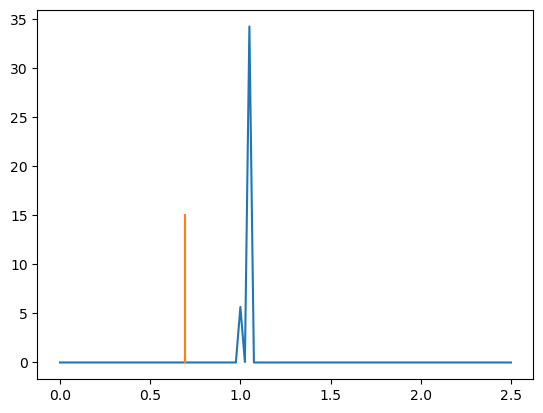

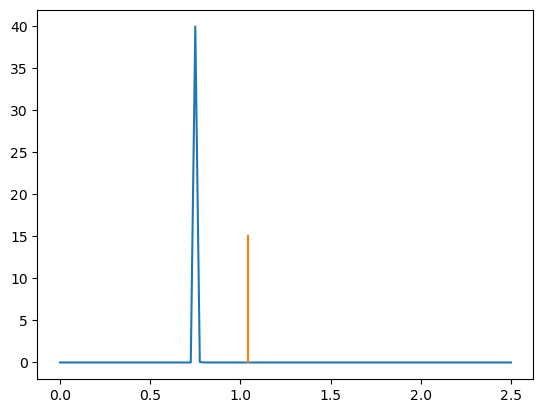

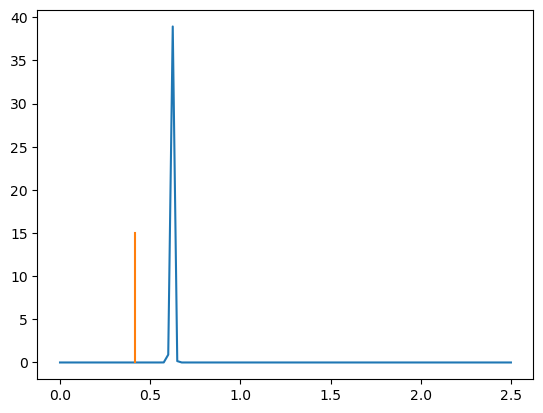

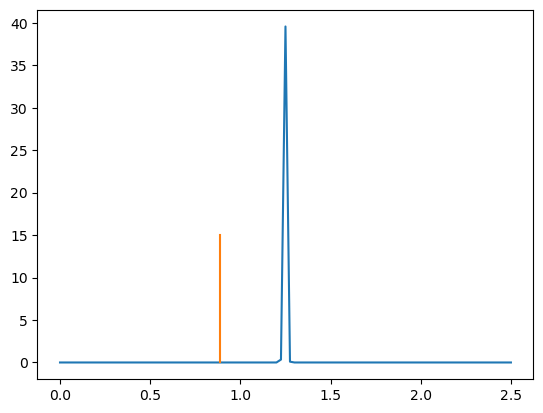

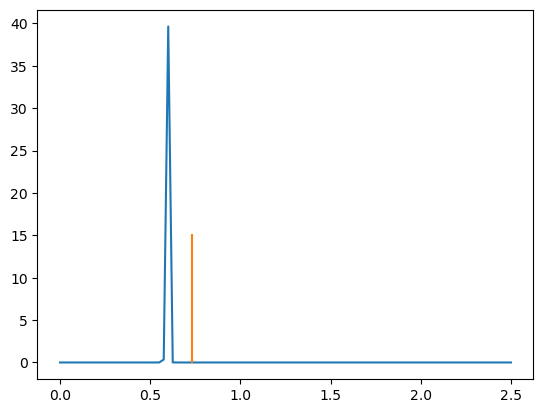

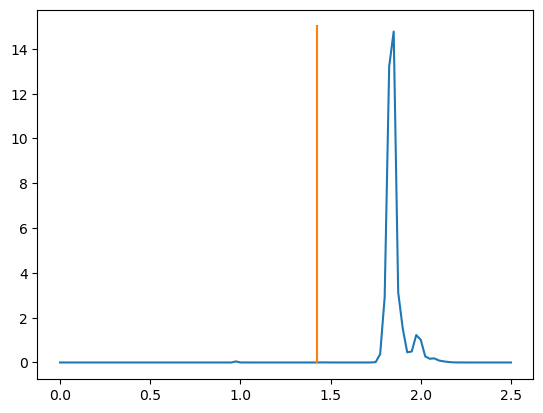

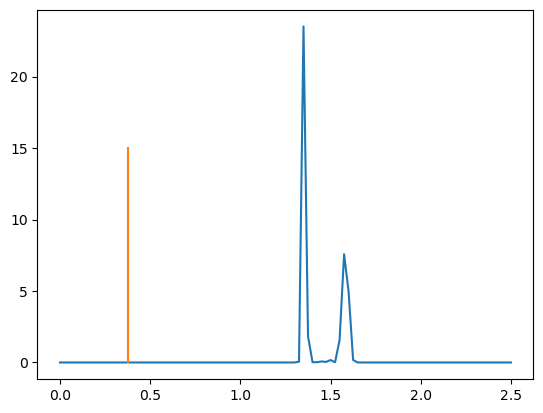

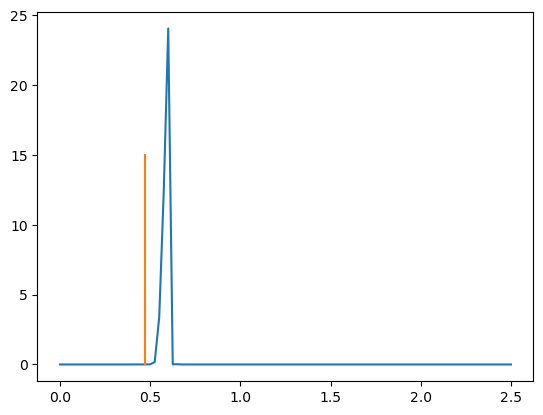

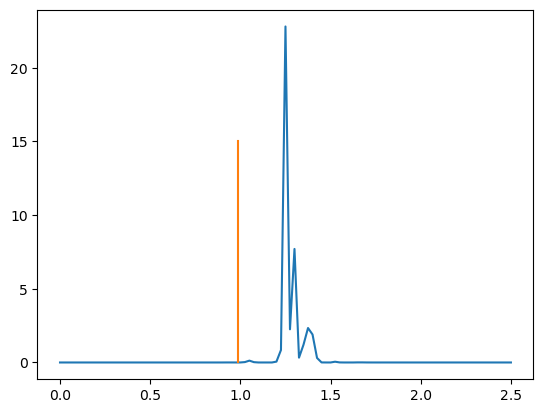

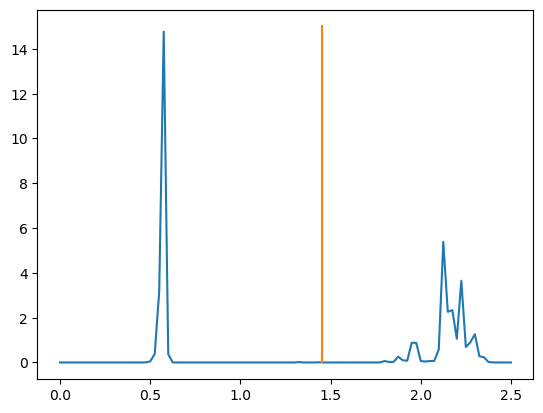

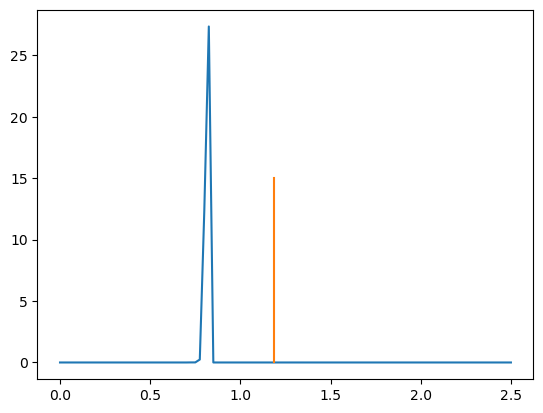

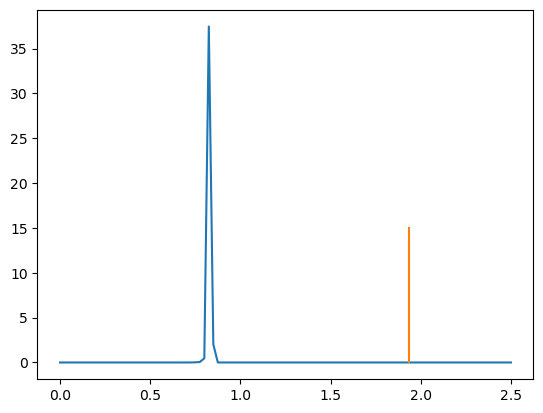

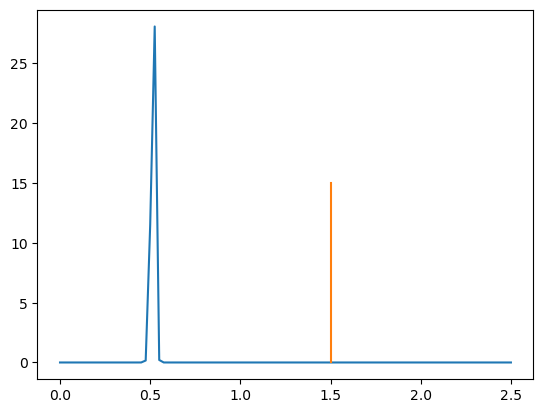

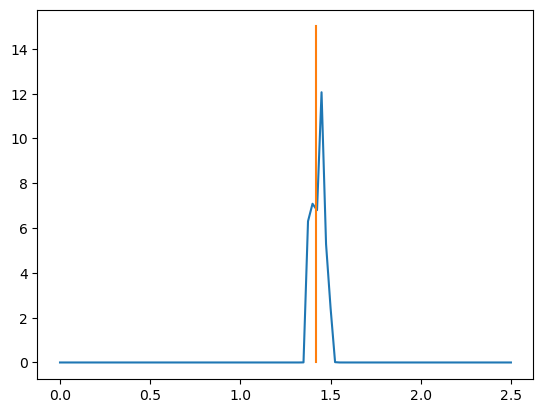

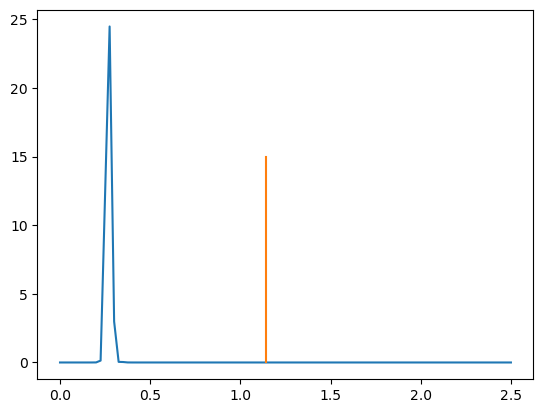

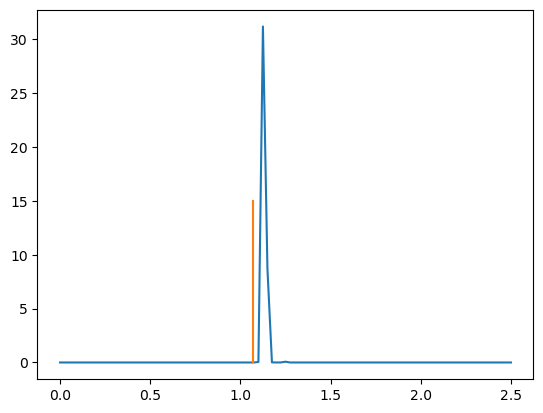

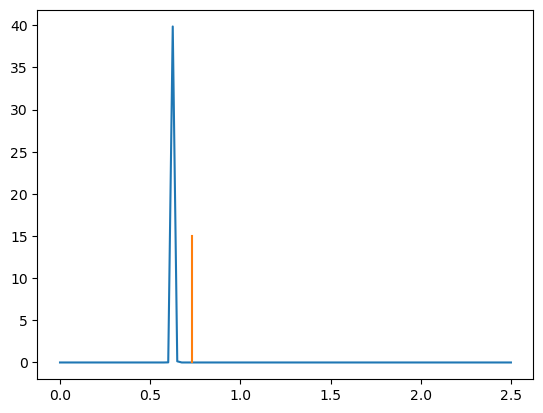

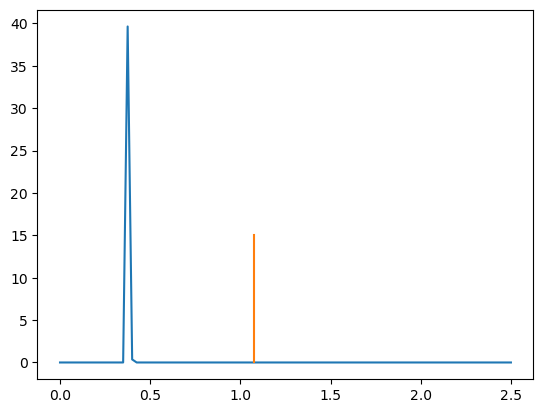

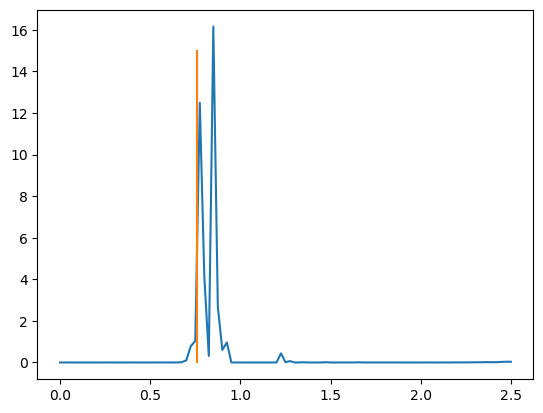

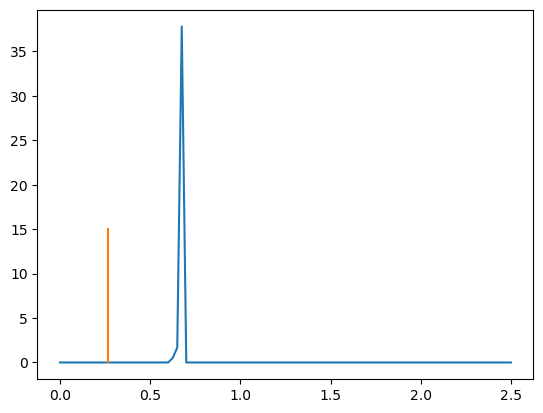

In [32]:
import matplotlib.pyplot as plt


for i in poststable_inds[20:40]:

    plt.plot(postsfile['meta']['xvals'][0],postsfile['data']['yvals'][i])
    plt.plot(poststable['redshift'][i] * np.ones(len(postsfile['meta']['xvals'][0])), np.linspace(0, 15, len(postsfile['meta']['xvals'][0])))
    plt.show()

# Column Remappers

In [11]:
bands = ['u','g','r','i','z','y']
band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

def colRemapper_1(dict):
    col_remap = ColumnMapper.make_stage(
    name='col_remapper_1', 
    columns=dict,
    )
    return col_remap

def colRemapper_2(dict):
    col_remap = ColumnMapper.make_stage(
    name='col_remapper_2', 
    columns=dict,
    )
    return col_remap

def tableConverter():
    table_conv = TableConverter.make_stage(
    name='table_conv', 
    output_format='numpyDict',
    )
    return table_conv

# Inform & Estimate

In [12]:
def informTrainZ(deg):
    inf = TrainZInformer.make_stage(
    name = 'inform_TrainZ',
    model = deg+'_trainz.pkl',
    hdf5_groupname=""
    )
    return inf

def estimateTrainZ(deg):
    est = TrainZEstimator.make_stage(
    name = 'estimate_TrainZ',
    model = deg+'_trainz.pkl', 
    hdf5_groupname=""
    )
    return est

In [13]:
def informCMNN(deg):
    inf = Inform_CMNNPDF.make_stage(
    name = 'inform_CMNN',
    model = deg+'_cmnn.pkl',
    hdf5_groupname=""
    )
    return inf

def estimateCMNN(deg):
    est = CMNNPDF.make_stage(
    name = 'estimate_CMNN',
    model = deg+'_cmnn.pkl', 
    hdf5_groupname=""
    )
    return est

In [14]:
def informGPz(deg):
    inf = GPzInformer.make_stage(
    name = 'inform_GPz',
    model = deg+'_gpz.pkl',
    hdf5_groupname=""
    )
    return inf

def estimateGPz(deg):
    est = GPzEstimator.make_stage(
    name = 'estimate_GPz',
    model = deg+'_gpz.pkl', 
    hdf5_groupname=""
    )
    return est

In [15]:
def informFZBoost(deg):
    info = FlexZBoostInformer.make_stage(
    name ='inform_FZBoost', 
    model = deg+'_fzboost.pkl', 
    hdf5_groupname='',
    )
    return info

def estimateFZBoost(deg):
    est = FlexZBoostEstimator.make_stage(
    name='estimate_FZBoost', 
    nondetect_val=np.nan,
    model= deg+'_fzboost.pkl', 
    hdf5_groupname='',
    # aliases=dict(input='test_data', output='fzboost_estim'),
    nzbins = 100 
    )
    return est 

### PZFlow

In [19]:
# def informPZFlow():
#     inf = PZFlowInformer.make_stage(
#     name = 'inform_PZFlow',
#     model = 'pzflow.pkl',
#     hdf5_groupname=""
#     )
#     return inf

# def estimatePZFlow(info):
#     est = PZFlowEstimator.make_stage(
#     name = 'estimate_PZFlow',
#     model = 'pzflow.pkl', 
#     hdf5_groupname=""
#     )
#     return est

In [ ]:
## ONLY RUN THESE CELLS IN rail_6-4-24 AND ONLY FOR PZFlow; EVERYTHING ELSE RUNS IN rail---new ## 

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
import pandas as pd
from astropy.table import QTable, Table, Column
from collections import OrderedDict

In [2]:
import rail
import qp
from rail.core.data import TableHandle
from rail.core.stage import RailStage

In [3]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [4]:
dir = "/Users/alicec03/Desktop/Summer_Research/rail_pzflow/src"
os.chdir(dir)

from rail.estimation.algos.pzflow_nf_default import PZFlowInformer, PZFlowEstimator

pzflow_dict = dict(hdf5_groupname='', output_mode = 'not_default', )


In [29]:
def informPZFlow():
    inf = PZFlowInformer.make_stage(
    name = 'inform_PZFlow', 
    model = 'pzflow.pkl', 
    num_training_epochs = 150,
    **pzflow_dict
    )
    inf._aliases = dict()
    return inf 

def estimatePZFlow():
    est = PZFlowEstimator.make_stage(
    name='estimate_pzflow',
    model='pzflow.pkl',
    **pzflow_dict, 
    chunk_size = 15000
    )
    est._aliases = dict()
    return est 

In [31]:
import pandas as pd

In [32]:
df1 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs/VVDSf02/output_specselection_VVDSf02.pq")
df2 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs/VVDSf02/output_lsst_error_0.pq")

In [33]:
df2

redshift  mag_g_lsst  mag_g_lsst_err  mag_i_lsst  mag_i_lsst_err  \
4       1.068016   23.978469        0.011595   22.860390        0.007493   
6       0.729724   24.271791        0.014487   21.572772        0.005326   
13      1.206573   23.103431        0.006961   22.540720        0.006535   
26      0.215827   22.794806        0.006230   21.783998        0.005459   
52      0.689987   24.717080        0.020889   22.246049        0.005965   
...          ...         ...             ...         ...             ...   
999957  0.619409   24.688354        0.020387   23.322299        0.009799   
999958  1.373877   26.298010        0.083706   23.456470        0.010741   
999961  0.783317   25.258889        0.033402   22.301409        0.006054   
999980  0.456077   23.431141        0.008157   21.429680        0.005260   
999997  0.533817   23.989480        0.011688   21.543363        0.005311   

        mag_r_lsst  mag_r_lsst_err  mag_u_lsst  mag_u_lsst_err  mag_y_lsst  \
4        23.314348        0.007530   24.531861        0.053686   21.961038   
6        22.558188        0.005782   25.978886        0.188455   20.646691   
13       22.809979        0.006168   23.279126        0.018320   21.598146   
26       22.063238        0.005352   23.812103        0.028652   21.490427   
52       23.349481        0.007664   25.652222        0.142748   21.642794   
...            ...             ...         ...             ...         ...   
999957   23.897355        0.010719   25.338773        0.108888   22.966369   
999958   25.293554        0.033811   27.964888        0.844511   22.196400   
999961   23.643681        0.009057   32.276515        4.504955   21.443400   
999980   21.917461        0.005278   24.940655        0.076896   20.753229   
999997   22.493601        0.005705   26.299851        0.246156   20.870395   

        mag_y_lsst_err  mag_z_lsst  mag_z_lsst_err  
4             0.011332   22.207543        0.007454  
6             0.005927   20.985653        0.005360  
13            0.008887   21.937022        0.006631  
26            0.008339   21.655770        0.006052  
52            0.009136   21.926291        0.006605  
...                ...         ...             ...  
999957        0.025677   23.104256        0.013302  
999958        0.013526   22.912250        0.011513  
999961        0.008122   21.800529        0.006320  
999980        0.006097   21.126787        0.005451  
999997        0.006319   21.147691        0.005467  

[137241 rows x 13 columns]

In [34]:
lsu = df2.index[np.isnan(df2['mag_u_lsst']) ==True].tolist() 
lsg = df2.index[np.isnan(df2['mag_g_lsst']) ==True].tolist() 
lsr = df2.index[np.isnan(df2['mag_r_lsst']) ==True].tolist() 
lsi = df2.index[np.isnan(df2['mag_i_lsst']) ==True].tolist() 
lsz = df2.index[np.isnan(df2['mag_z_lsst']) ==True].tolist() 
lsy = df2.index[np.isnan(df2['mag_y_lsst']) ==True].tolist() 


# print(list(set(lsu+lsg + lsr+ lsi+lsz+lsy)))


In [37]:
col_names = ['mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst']

# loc = 0
# for loc in range(0, len(df2['redshift'])):
#     row = df2[loc:loc+1]
#     for name in col_names:
#         print(row[name])
#         #if np.isnan(row[name]) == True:
#             #print('AAA')
#     loc += 1

# loc = 15
# row = df2[loc:loc+1]
# #print(row)
# print(row['mag_g_lsst'])

In [40]:
ct = 0
for i in df2['mag_z_lsst']:
    if np.isnan(i) == True:
        ct += 1
        # print(i, ct)
print(str(ct)+ ' nans')

343 nans


In [31]:
data1 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/1.0/output_lsst_error_0.pq")
data2 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/1.0/output_inv_redshift.pq")

In [32]:
data1

redshift  mag_g_lsst  mag_g_lsst_err  mag_i_lsst  mag_i_lsst_err  \
0      0.966559   24.697981        0.020554   22.690358        0.006931   
1      1.059953   25.621688        0.046017   24.197568        0.019213   
2      0.570302   28.383380        0.471983   25.696458        0.071624   
4      0.341016   26.144901        0.073134   25.286391        0.049785   
5      0.712270   24.458110        0.016830   23.199302        0.009054   
...         ...         ...             ...         ...             ...   
99994  0.464899   26.762184        0.125594   25.813217        0.079409   
99995  0.648156   28.863500        0.666268   25.634096        0.067777   
99996  1.257911   26.128194        0.072063   25.453699        0.057758   
99997  1.652583   26.951892        0.147925   25.471360        0.058670   
99999  0.282815   27.381765        0.212929   26.462072        0.139976   

       mag_r_lsst  mag_r_lsst_err  mag_u_lsst  mag_u_lsst_err  mag_y_lsst  \
0       23.450827        0.008088   25.449445        0.119858   21.535051   
1       24.823453        0.022434   26.151518        0.217748   23.274423   
2       26.405758        0.090526   31.017384        3.282711   25.043283   
4       25.359434        0.035836   26.514136        0.293040   25.130427   
5       23.805980        0.010064   24.773335        0.066386   23.089466   
...           ...             ...         ...             ...         ...   
99994   25.891819        0.057465   32.937456        5.158052   25.129838   
99995   26.697650        0.116870   27.369025        0.563287   24.914419   
99996   25.807632        0.053327   25.838849        0.167406   24.394950   
99997   25.992044        0.062809         NaN             NaN   24.499793   
99999   26.642246        0.111362   27.211730        0.502403   25.799901   

       mag_y_lsst_err  mag_z_lsst  mag_z_lsst_err  
0            0.008558   21.846427        0.006418  
1            0.033632   23.495452        0.018242  
2            0.159229   25.563890        0.111855  
4            0.171511   25.008434        0.068623  
5            0.028587   23.111844        0.013380  
...               ...         ...             ...  
99994        0.171425   25.346420        0.092465  
99995        0.142563   25.310327        0.089577  
99996        0.090685   24.862871        0.060318  
99997        0.099426   24.991590        0.067607  
99999        0.298787   26.195966        0.192470  

[85459 rows x 13 columns]

In [33]:
data2

redshift  mag_g_lsst  mag_i_lsst  mag_r_lsst  mag_u_lsst  mag_y_lsst  \
0      0.966559   24.721041   22.692711   23.446445   25.300295   21.518806   
1      1.059953   25.584215   24.180773   24.818432   26.139088   23.199163   
2      0.570302   27.575546   25.843550   26.462980   28.492306   25.302023   
4      0.341016   26.198450   25.291866   25.400103   26.946693   24.973673   
5      0.712270   24.463943   23.197393   23.782991   24.921415   23.028093   
...         ...         ...         ...         ...         ...         ...   
99994  0.464899   26.947382   25.712088   25.966135   27.622187   25.287737   
99995  0.648156   28.063946   25.650227   26.594429   29.282473   25.099009   
99996  1.257911   26.042486   25.415533   25.832323   26.238253   24.347881   
99997  1.652583   26.878645   25.496140   26.155291   28.357960   24.551855   
99999  0.282815   27.710808   26.278656   26.609695   29.211800   25.880888   

       mag_z_lsst  
0       21.846548  
1       23.512583  
2       25.566341  
4       24.965878  
5       23.084066  
...           ...  
99994   25.510817  
99995   25.411396  
99996   24.835291  
99997   24.988556  
99999   26.019693  

[85459 rows x 7 columns]

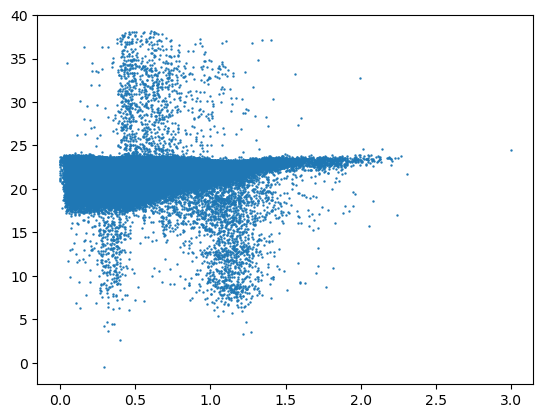

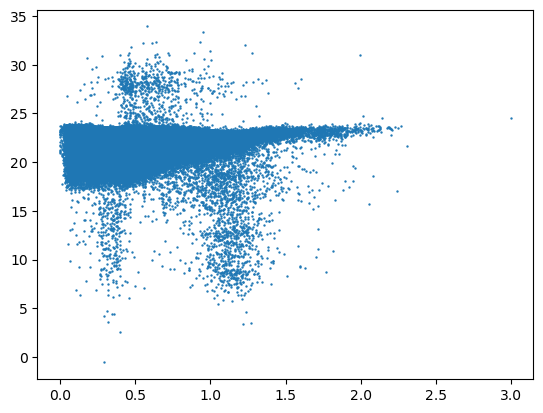

In [37]:
plt.scatter(df1['redshift'], df1['mag_z_lsst'], s=0.5)
plt.show()
plt.scatter(df2['redshift'], df2['mag_z_lsst'], s=0.5)
plt.show()

In [20]:
os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/outputs/BOSS/")
trainFile = DS.read_file("training_data", TableHandle, "./output_lsst_error_0.pq")

informPZFlow().inform(trainFile)

column_list None
Training 150 epochs 
Loss:
(0) inf
(1) inf
Training stopping after epoch 1 because training loss diverged.


In [42]:
os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs/1.0/")
testFile = DS.read_file('test_data', TableHandle, "./output_lsst_error.pq")
estimatePZFlow().estimate(testFile)

column_list None
Process 0 running estimator on chunk 0 - 10000


/Users/alicec03/miniforge3/envs/rail_6-4-24/lib/python3.10/site-packages/qp/interp_pdf.py:89: RuntimeWarning: invalid value encountered in divide
  self._ycumul = (self._ycumul.T / self._ycumul[:, -1]).T


Inserting handle into data store.  output_estimate_pzflow: inprogress_output_estimate_pzflow.hdf5, estimate_pzflow


In [44]:
import h5py

os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs/1.0/")
pzflow_out = h5py.File("./output_estimate_PZFlow.hdf5")

In [45]:
pzflow_out.keys()

<KeysViewHDF5 ['ancil', 'data', 'meta']>

In [58]:
# import ceci 

# pr = ceci.Pipeline.read(path_lst_1[0])#parent_dir+directory+"/invz=0.33672517538070684_lsstErr_pzflow.yml")
# pr.run()

# ## 1) terminal: go to path up to invz_lsstErr_pzflow, then run these 2 lines 
# ## 2)  make list/txt file with list of paths to files made by big F

# ## do 1) 
# ## open virtual env
# ## python 
# ## import ceci 
# ## run the 2 lines of code above 


# ### at the end we can put this into a .py file that we can run at the command line 

# ## %cd ? 

In [59]:
## more config parameters/better config parameters
## have to give path above to estimator model instead of get_handle('model')
## fix truncated parameter printing in help(...)

# Big F's

In [19]:
# ## for inverse redshift incompleteness:

# pivot_ls = [1.0, 1.4, 'LSSTerr_only']#, 'control'] 

# name_ls = ['BOSS', 'DEEP2', 'GAMA', 'HSC', 'VVDSf02', 'zCOSMOS']

In [16]:
# 'invz': invRedshift,

deg_ls = ['BOSS', 'DEEP2', 'GAMA', 'HSC', 'VVDSf02', 'zCOSMOS', 'invz=1.0', 'invz=1.4', 'LSSTerr_only', 'control']



In [17]:
ntrain = 1e6 # 10e6
seed = 17

deg_dict = {'BOSS': [specSelectBOSS(ntrain), lsstError_0(band_dict, seed)], 
            'DEEP2': [specSelectDEEP2(ntrain), lsstError_0(band_dict, seed)], 
            'GAMA': [specSelectGAMA(ntrain), lsstError_0(band_dict, seed)], 
            'HSC': [specSelectHSC(ntrain), lsstError_0(band_dict, seed)], 
            'VVDSf02': [specSelectVVDSf02(ntrain), lsstError_0(band_dict, seed)], 
            'zCOSMOS': [specSelectzCOSMOS(ntrain), lsstError_0(band_dict, seed)], 
            'invz=1.0': [invRedshift(1.0), lsstError_0(band_dict, seed)], 
            'invz=1.4': [invRedshift(1.4), lsstError_0(band_dict, seed)], 
            'LSSTerr_only': [lsstError_0(band_dict, seed)], 
            'control': [lsstError_null(band_dict, seed)],
            } 

In [18]:
lsstError = lsstError(band_dict, 39)
lsstError.connect_input(test_data)

qcuts_2 = quantCuts_2(qcuts_dict)
qcuts_2.connect_input(lsstError)

Inserting handle into data store.  output_test_set: inprogress_output_test_set.pq, test_set
Inserting handle into data store.  output_lsst_error: inprogress_output_lsst_error.pq, lsst_error


In [19]:
def bigF(est, deg, pathname): 
    bands = ['u','g','r','i','z','y']
    band_dict = {band: f"mag_{band}_lsst" for band in bands}
    band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

    inf_est_dict = {'TrainZ': [informTrainZ(deg), estimateTrainZ(deg)],
               'CMNN': [informCMNN(deg), estimateCMNN(deg)], 
               'GPz': [informGPz(deg), estimateGPz(deg)], 
               # 'PZFlow': [informPZFlow(), estimatePZFlow()], 
               'FZBoost': [informFZBoost(deg), estimateFZBoost(deg)] }
    
    if deg in ['BOSS', 'DEEP2', 'GAMA', 'HSC', 'VVDSf02', 'zCOSMOS']:
        training_data = spec_train_data
    
    if deg in ['invz=1.0', 'invz=1.4', 'LSSTerr_only', 'control']:
        training_data = invz_train_data

    degraders = deg_dict[deg]

    informer = inf_est_dict[est][0]
    estimator = inf_est_dict[est][1]

    qcuts_1 = quantCuts_1(qcuts_dict)

    pipe = ceci.Pipeline.interactive()
    stages = [training_data, 
              test_data, 
              lsstError, 
              qcuts_1,
              qcuts_2,
              informer, 
              estimator
              ]

    if len(degraders)==2:
        selection = degraders[0]
        lsst = degraders[1]
        stages.append(selection)
        stages.append(lsst)
        selection.connect_input(training_data)
        lsst.connect_input(selection)
        qcuts_1.connect_input(lsst)

    elif len(degraders)==1:
        lsst = degraders[0]
        stages.append(lsst)
        lsst.connect_input(training_data)
        qcuts_1.connect_input(lsst)


    remapper_1 = colRemapper_1(band_dict_err)
    remapper_2 = colRemapper_2(band_dict_err)

    if est == 'CMNN' or est == 'GPz':
        stages.append(remapper_1)
        stages.append(remapper_2)

        remapper_1.connect_input(qcuts_1)
        informer.connect_input(remapper_1)

        remapper_2.connect_input(qcuts_2)
        estimator.connect_input(remapper_2, inputTag = 'input')

    else: 
        informer.connect_input(qcuts_1)
        estimator.connect_input(qcuts_2, inputTag = 'input')

    estimator.connect_input(informer, inputTag = 'model')

    for stage in stages:
        pipe.add_stage(stage)

    pipe.initialize(
    dict(model=flow_file), dict(output_dir=".", log_dir=".", resume=False), None) 

    outpath = os.path.join(pathname, deg+'_'+est+'.yml')#"% s_.yml" % deg+'_'+est)
    pipe.save(outpath)
    return outpath 
    

In [20]:
def makeItHelperFunc(est):
    path = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"+est
    os.chdir(path)

    path_ls = []
    for key in deg_dict:
        os.chdir(path)
        working_path = os.path.join(path, key)
        os.makedirs(working_path, exist_ok = True)
        os.chdir(working_path)
        path_ls.append(bigF(est, key, working_path))
    
    return path_ls 

In [21]:
TrainZ_path_ls = makeItHelperFunc('TrainZ')

Inserting handle into data store.  output_spec_train_set: inprogress_output_spec_train_set.pq, spec_train_set
Inserting handle into data store.  output_specselection_boss: inprogress_output_specselection_boss.pq, specselection_boss
Inserting handle into data store.  output_lsst_error_0: inprogress_output_lsst_error_0.pq, lsst_error_0
Inserting handle into data store.  output_quantity_cut_1: inprogress_output_quantity_cut_1.pq, quantity_cut_1
Inserting handle into data store.  output_quantity_cut_2: inprogress_output_quantity_cut_2.pq, quantity_cut_2
Inserting handle into data store.  model_inform_TrainZ: inprogress_BOSS_trainz.pkl, inform_TrainZ
Inserting handle into data store.  output_specselection_deep2: inprogress_output_specselection_deep2.pq, specselection_deep2
Inserting handle into data store.  output_specselection_gama: inprogress_output_specselection_gama.pq, specselection_gama
Inserting handle into data store.  output_specselection_HSC: inprogress_output_specselection_HSC.pq

In [48]:
CMNN_path_ls = makeItHelperFunc("CMNN")

Inserting handle into data store.  output_col_remapper_1: inprogress_output_col_remapper_1.pq, col_remapper_1
Inserting handle into data store.  output_col_remapper_2: inprogress_output_col_remapper_2.pq, col_remapper_2
Inserting handle into data store.  model_inform_CMNN: inprogress_BOSS_cmnn.pkl, inform_CMNN


In [49]:
GPz_path_ls = makeItHelperFunc("GPz")

Inserting handle into data store.  model_inform_GPz: inprogress_BOSS_gpz.pkl, inform_GPz


In [50]:
FZBoost_path_ls = makeItHelperFunc("FZBoost")

Inserting handle into data store.  model_inform_FZBoost: inprogress_BOSS_fzboost.pkl, inform_FZBoost


In [22]:
import ceci 

def runItHelperFunc(est, path_ls):
    path = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"+est 
    os.chdir(path)
    ct = 0
    for deg in deg_ls: 
        os.chdir(path+'/'+deg)
        pr = ceci.Pipeline.read(path_ls[ct])
        pr.run()
        ct += 1

In [23]:
runItHelperFunc('TrainZ', TrainZ_path_ls)


Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/1e6_trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/BOSS/BOSS_TrainZ_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out

Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/BOSS/BOSS_TrainZ_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing quantity_cut_2
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.

In [51]:
runItHelperFunc('CMNN', CMNN_path_ls)


Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/1e6_trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/CMNN/BOSS/BOSS_CMNN_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out

Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/CMNN/BOSS/BOSS_CMNN_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing col_remapper_2
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.core.utilStages.ColumnMapper 

KeyboardInterrupt: 

In [49]:
runItHelperFunc('GPz', GPz_path_ls)


Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/5e5_trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/GPz/BOSS/BOSS_GPz_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out

Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/GPz/BOSS/BOSS_GPz_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing col_remapper_2
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.core.utilStages.ColumnMapper   --

In [50]:
runItHelperFunc('FZBoost', FZBoost_path_ls)


Executing test_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/5e5_trained_flow.pkl   --name=test_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/FZBoost/BOSS/BOSS_FZBoost_config.yml   --output=./output_test_set.pq 
Output writing to ./test_set.out

Job test_set has completed successfully!

Executing lsst_error
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_test_set.pq   --name=lsst_error   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/FZBoost/BOSS/BOSS_FZBoost_config.yml   --output=./output_lsst_error.pq 
Output writing to ./lsst_error.out

Job lsst_error has completed successfully!

Executing spec_train_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.

In [51]:
lets make an error 

SyntaxError: invalid syntax (477353185.py, line 1)

In [ ]:
import pandas as pd

deg_file = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/GAMA/output_specselection_gama.pq"
undeg_file = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/GAMA/output_spec_train_set.pq"
deg = pd.read_parquet(deg_file)
orig = pd.read_parquet(undeg_file)

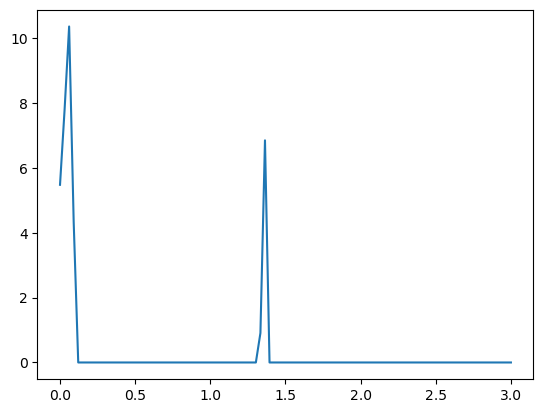

In [65]:
outpath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/FZBoost/zCOSMOS/output_estimate_FZBoost.hdf5"

import h5py
outfile = h5py.File(outpath)

import matplotlib.pyplot as plt

x = outfile['meta']['xvals'][0]
y = outfile['data']['yvals'][0]

plt.plot(outfile['meta']['xvals'][0], outfile['data']['yvals'][3])

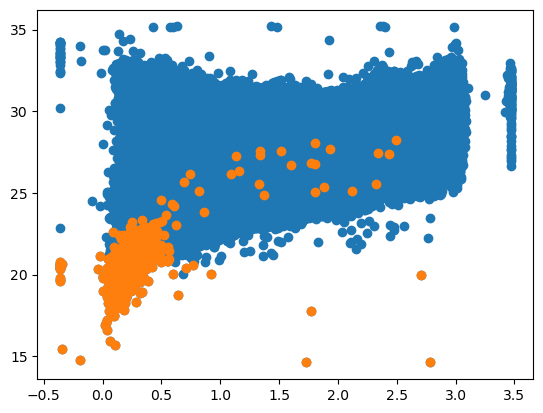

In [ ]:
import matplotlib.pyplot as plt


plt.scatter(orig['redshift'], orig['mag_u_lsst'])
plt.scatter(deg['redshift'], deg['mag_u_lsst'])

In [ ]:
len(deg['redshift']) 

1171

In [ ]:
print(len(set(deg['redshift'])))

509


In [ ]:
cut1_path = '/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/5e5_cut_rubin_roman_catalog.pq'
cut2_path = '/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/1.5e6_cut_rubin_roman_catalog.pq'

cut1 = pd.read_parquet(cut1_path)
cut2 = pd.read_parquet(cut2_path)


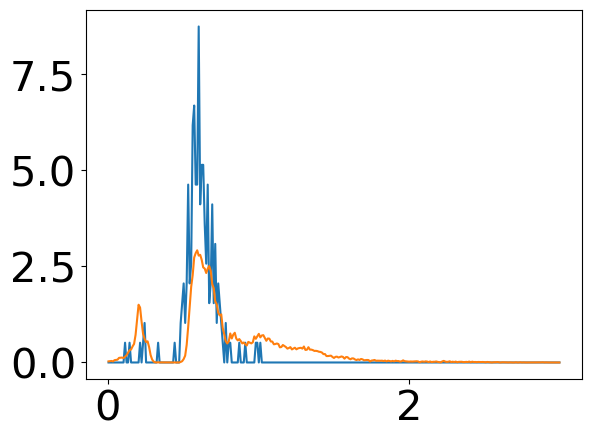

In [47]:
import h5py
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size':10})

filepath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/BOSS/output_estimate_TrainZ.hdf5"
file = h5py.File(filepath)
filepath2 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/DEEP2/output_estimate_TrainZ.hdf5"
file2 = h5py.File(filepath2)

plt.plot(file['meta']['xvals'][0], file['data']['yvals'][2])
plt.plot(file2['meta']['xvals'][0], file2['data']['yvals'][2])

# Visualizing Training Sets 

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

spec_set = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/BOSS/output_spec_train_set.pq') ) 
boss_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/BOSS/output_quantity_cut_1.pq') ) 
deep2_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/DEEP2/output_quantity_cut_1.pq') ) 
gama_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/GAMA/output_quantity_cut_1.pq') ) 
hsc_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/HSC/output_quantity_cut_1.pq') ) 
vvdsf02_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/VVDSf02/output_quantity_cut_1.pq') ) 
zcosmos_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/zCOSMOS/output_quantity_cut_1.pq') ) 

invz_set = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/invz=1.0/output_invz_train_set.pq') ) 
one_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/invz=1.0/output_quantity_cut_1.pq') ) 
onefour_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/invz=1.4/output_quantity_cut_1.pq') ) 
lssterr_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/lsstErr_only/output_quantity_cut_1.pq'))
control_deg = removeNans(pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/control/output_quantity_cut_1.pq'))


In [44]:
lssterr_deg

redshift  mag_u_lsst  mag_u_lsst_err  mag_g_lsst  mag_g_lsst_err  \
1      1.054636   26.029941        0.196718   25.989000        0.063716   
2      1.459551   27.251481        0.517280   25.751986        0.051649   
3      2.264151   24.725556        0.063655   24.789002        0.022208   
5      1.466277   27.497798        0.617208   26.638571        0.112805   
7      2.319523   27.267426        0.523344   26.926090        0.144682   
...         ...         ...             ...         ...             ...   
99995  0.580322   24.967074        0.078699   24.280092        0.014583   
99996  1.277328   25.255274        0.101257   25.244916        0.032994   
99997  1.275763   25.200718        0.096552   25.215429        0.032151   
99998  0.888939   26.143648        0.216327   25.698442        0.049255   
99999  2.464515   27.532621        0.632431   27.075849        0.164475   

       mag_r_lsst  mag_r_lsst_err  mag_i_lsst  mag_i_lsst_err  mag_z_lsst  \
1       25.905915        0.058189   25.609471        0.066314   25.348113   
2       25.535597        0.041886   25.104890        0.042377   24.623774   
3       24.800883        0.022003   24.871012        0.034453   25.029753   
5       26.587060        0.106123   26.784745        0.184399   26.769778   
7       26.883526        0.137300   27.271110        0.276106   28.102732   
...           ...             ...         ...             ...         ...   
99995   23.061734        0.006729   22.289154        0.006034   22.178977   
99996   25.318854        0.034575   25.206069        0.046358   24.930474   
99997   25.280865        0.033435   25.222324        0.047032   24.718654   
99998   25.689894        0.048033   25.207289        0.046408   24.918350   
99999   26.940269        0.144180   27.908800        0.455168   28.590027   

       mag_z_lsst_err  mag_y_lsst  mag_y_lsst_err  
1            0.092603   24.869930        0.137199  
2            0.048785   23.997313        0.063828  
3            0.069930   25.005436        0.154154  
5            0.308668   26.140191        0.390840  
7            0.816764   30.028367        3.047242  
...               ...         ...             ...  
99995        0.007352   21.943902        0.011192  
99996        0.064044   24.525822        0.101719  
99997        0.053072   24.580351        0.106687  
99998        0.063359   25.053494        0.160624  
99999        1.101145   26.980358        0.719016  

[91216 rows x 13 columns]

Text(0.02, 0.5, 'Magnitude')

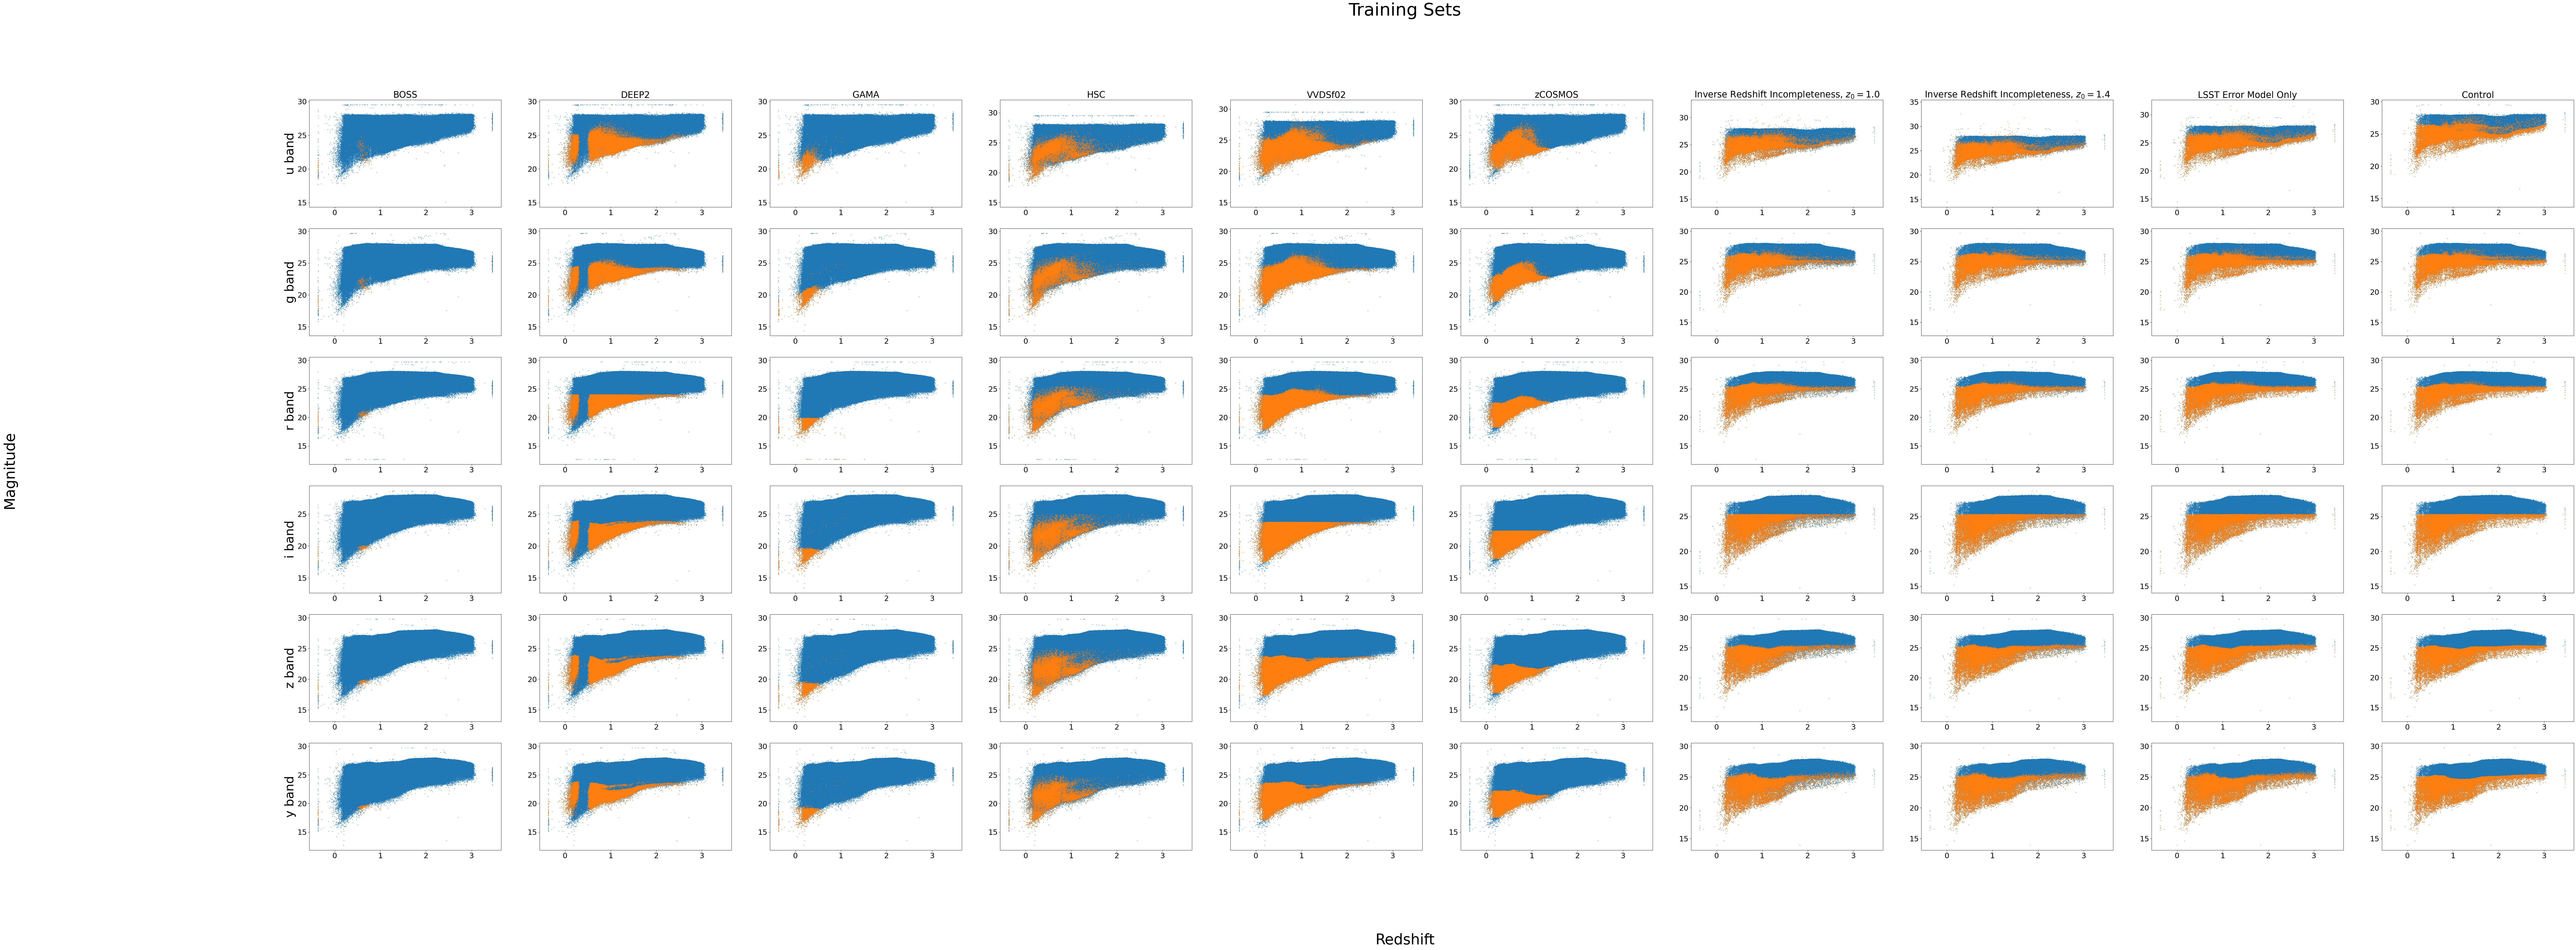

In [31]:
import matplotlib
matplotlib.rcParams.update({'font.size':22})

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 6, ncols = 10, figsize = (120, 40))
bands = ['u', 'g', 'r', 'i', 'z', 'y']
ct = 0
for band in bands: 
    axes[ct][0].scatter(spec_set['redshift'], spec_set['mag_'+band+'_lsst'], s=0.5)
    axes[ct][0].scatter(boss_deg['redshift'], boss_deg['mag_'+band+'_lsst'], s=0.5)
    # axes[ct][0].hist2d(boss_deg['redshift'], boss_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 28, 100)), density = True)

    axes[ct][1].scatter(spec_set['redshift'], spec_set['mag_'+band+'_lsst'], s=0.5)
    axes[ct][1].scatter(deep2_deg['redshift'], deep2_deg['mag_'+band+'_lsst'], s=0.5)
    # axes[ct][1].hist2d(deep2_deg['redshift'], deep2_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 28, 100)), density = True)

    axes[ct][2].scatter(spec_set['redshift'], spec_set['mag_'+band+'_lsst'], s=0.5)
    axes[ct][2].scatter(gama_deg['redshift'], gama_deg['mag_'+band+'_lsst'], s=0.5)
    # axes[ct][2].hist2d(gama_deg['redshift'], gama_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 28, 100)), density = True)

    axes[ct][3].scatter(spec_set['redshift'], spec_set['mag_'+band+'_lsst'], s=0.5)
    axes[ct][3].scatter(hsc_deg['redshift'], hsc_deg['mag_'+band+'_lsst'], s=0.5)
    # axes[ct][3].hist2d(hsc_deg['redshift'], hsc_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 28, 100)), density = True)

    axes[ct][4].scatter(spec_set['redshift'], spec_set['mag_'+band+'_lsst'], s=0.5)
    axes[ct][4].scatter(vvdsf02_deg['redshift'], vvdsf02_deg['mag_'+band+'_lsst'], s=0.5)
    # axes[ct][4].hist2d(vvdsf02_deg['redshift'], vvdsf02_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 28, 100)), density = True)

    axes[ct][5].scatter(spec_set['redshift'], spec_set['mag_'+band+'_lsst'], s=0.5)
    axes[ct][5].scatter(zcosmos_deg['redshift'], zcosmos_deg['mag_'+band+'_lsst'], s=0.5)
    # axes[ct][5].hist2d(zcosmos_deg['redshift'], zcosmos_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 28, 100)), density = True)


    axes[ct][6].scatter(invz_set['redshift'], invz_set['mag_'+band+'_lsst'], s=0.5)
    axes[ct][6].scatter(one_deg['redshift'], one_deg['mag_'+band+'_lsst'], s=0.5)
    # axes[ct][6].hist2d(one_deg['redshift'], one_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 28, 100)), density = True)

    axes[ct][7].scatter(invz_set['redshift'], invz_set['mag_'+band+'_lsst'], s=0.5)
    axes[ct][7].scatter(onefour_deg['redshift'], onefour_deg['mag_'+band+'_lsst'], s=0.5)
    # axes[ct][7].hist2d(onefour_deg['redshift'], onefour_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 28, 100)), density = True)

    axes[ct][8].scatter(invz_set['redshift'], invz_set['mag_'+band+'_lsst'], s=0.5)
    axes[ct][8].scatter(lssterr_deg['redshift'], lssterr_deg['mag_'+band+'_lsst'], s=0.5)
    # axes[ct][8].hist2d(lssterr_deg['redshift'], lssterr_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 28, 100)), density = True)

    axes[ct][9].scatter(invz_set['redshift'], invz_set['mag_'+band+'_lsst'], s=0.5)
    axes[ct][9].scatter(control_deg['redshift'], control_deg['mag_'+band+'_lsst'], s=0.5)
    # axes[ct][9].hist2d(control_deg['redshift'], control_deg['mag_'+band+'_lsst'], bins = (np.linspace(0, 3, 100), np.linspace(15, 28, 100)), density = True)


    ct += 1

axes[0][0].set_title("BOSS", size = 'large')
axes[0][1].set_title("DEEP2", size = 'large')
axes[0][2].set_title("GAMA", size = 'large')
axes[0][3].set_title("HSC", size = 'large')
axes[0][4].set_title("VVDSf02", size = 'large')
axes[0][5].set_title("zCOSMOS", size = 'large')
axes[0][6].set_title("Inverse Redshift Incompleteness, $z_0 = 1.0$", size = 'large')
axes[0][7].set_title("Inverse Redshift Incompleteness, $z_0 = 1.4$", size = 'large')
axes[0][8].set_title("LSST Error Model Only", size = 'large')
axes[0][9].set_title("Control", size = 'large')

matplotlib.rcParams.update({'font.size':30})

axes[0][0].set_ylabel('u band', size = 'large')
axes[1][0].set_ylabel('g band', size = 'large')
axes[2][0].set_ylabel('r band', size = 'large')
axes[3][0].set_ylabel('i band', size = 'large')
axes[4][0].set_ylabel('z band', size = 'large')
axes[5][0].set_ylabel('y band', size = 'large')

fig.suptitle("Training Sets", size = "xx-large")
fig.supxlabel("Redshift", size = 'x-large')
fig.supylabel("Magnitude", size = 'x-large')

# Visualizing Estimator Outputs

In [56]:
def gaussian(file, grid, ct):
    return (1. /(file['data']['scale'][ct] * np.sqrt(2*np.pi))) * np.exp((-1/2) * ((grid - file['data']['loc'][ct])/ file['data']['scale'][ct] )**2)

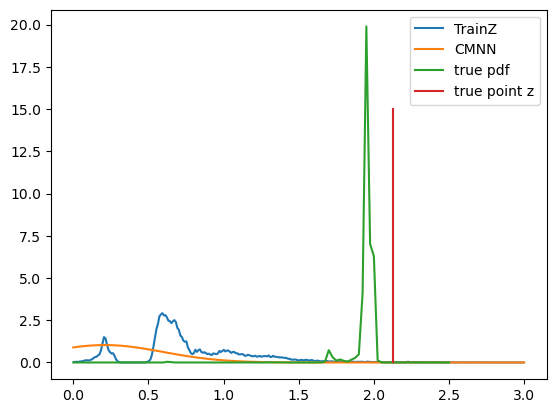

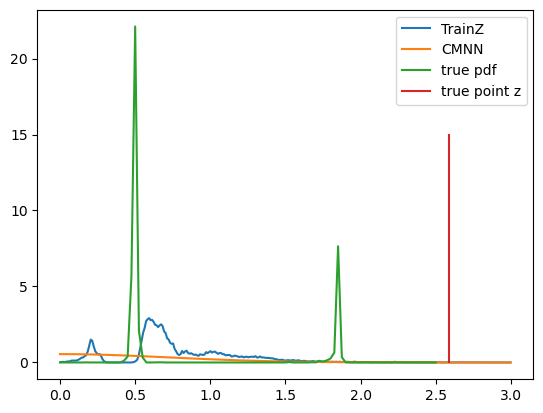

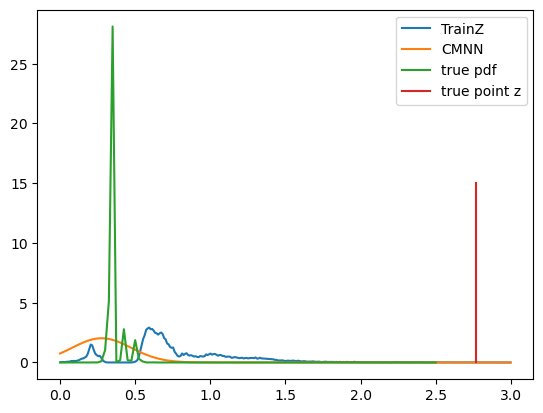

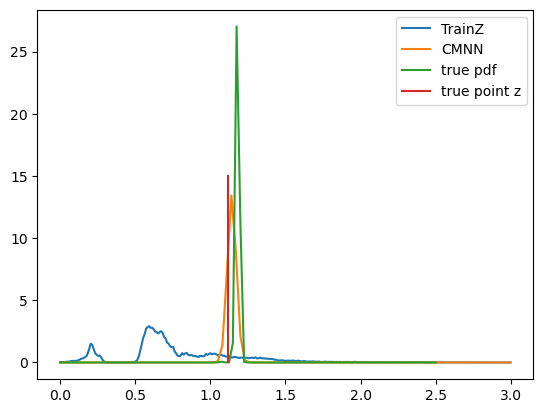

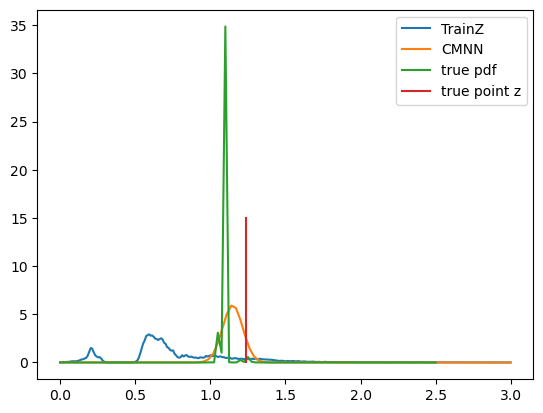

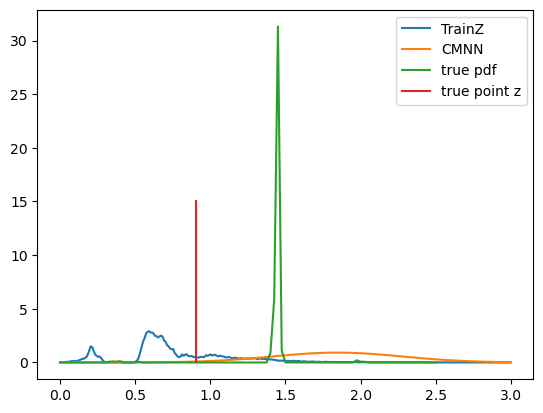

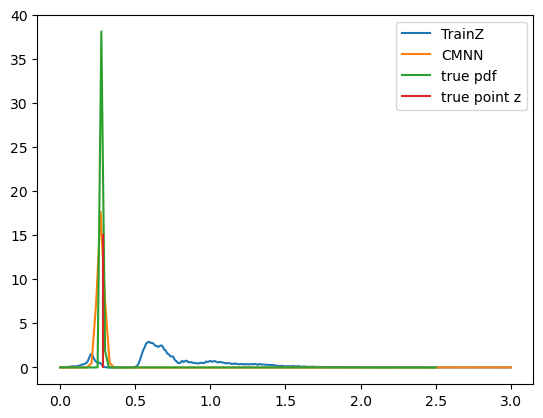

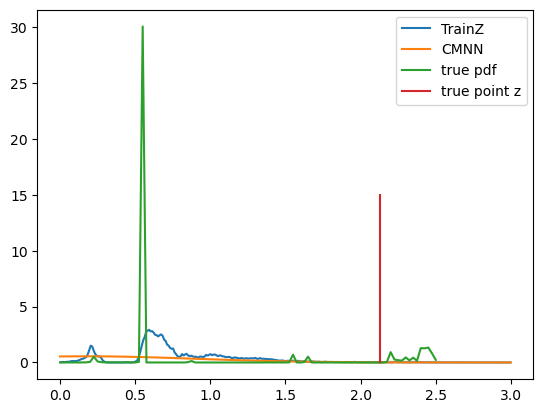

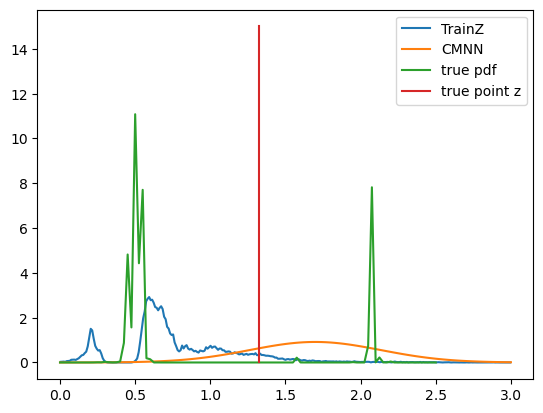

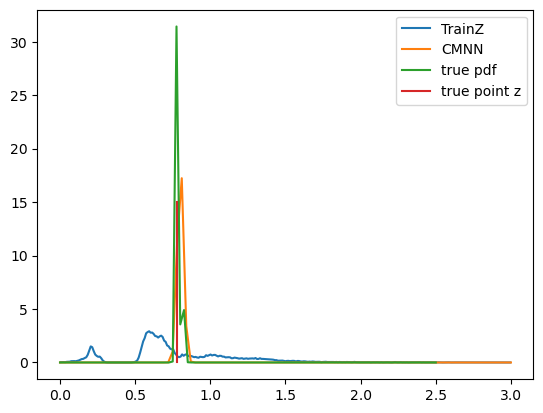

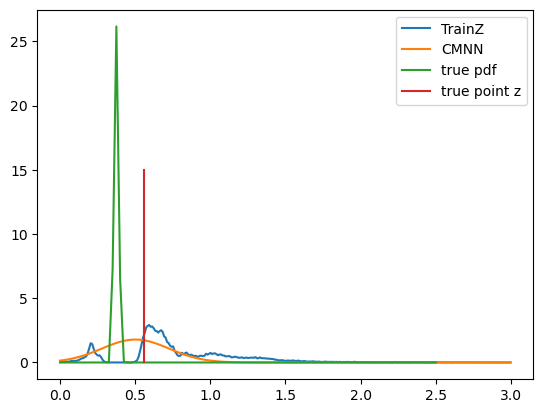

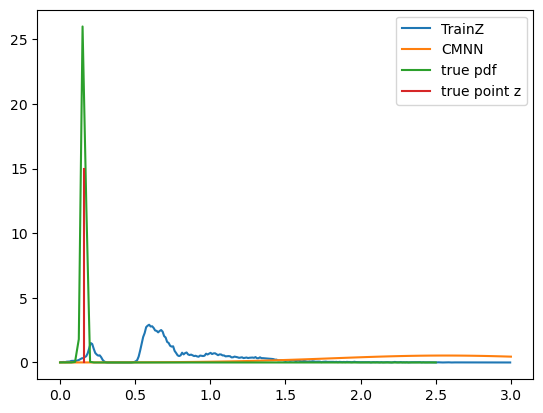

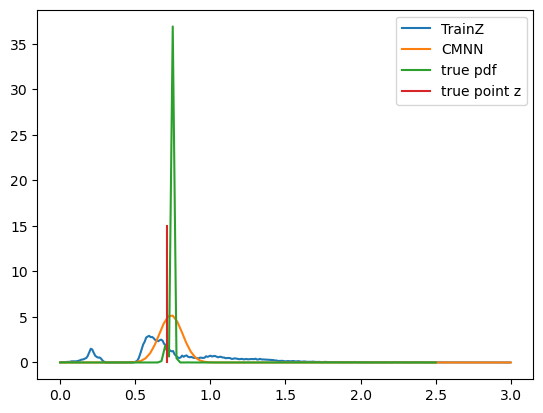

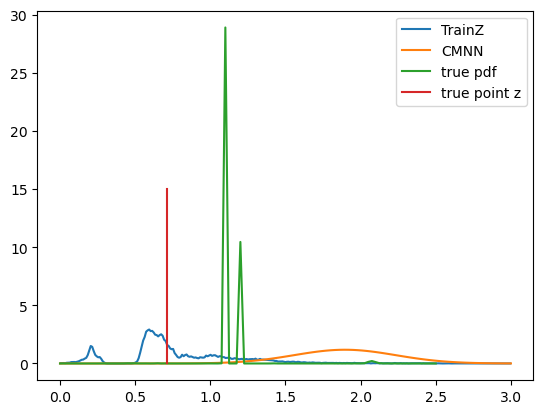

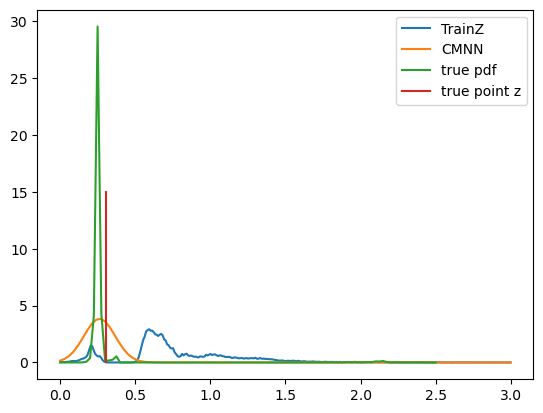

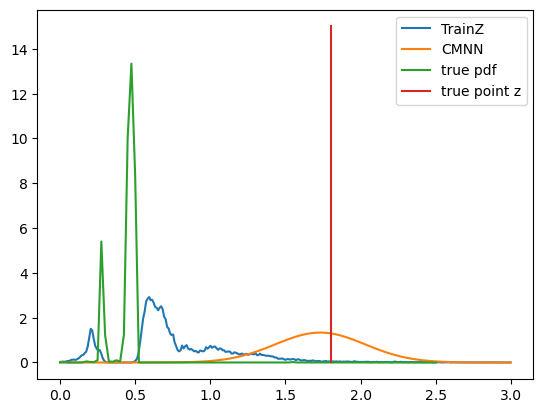

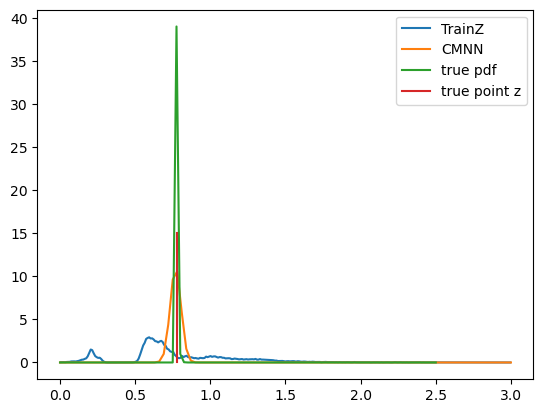

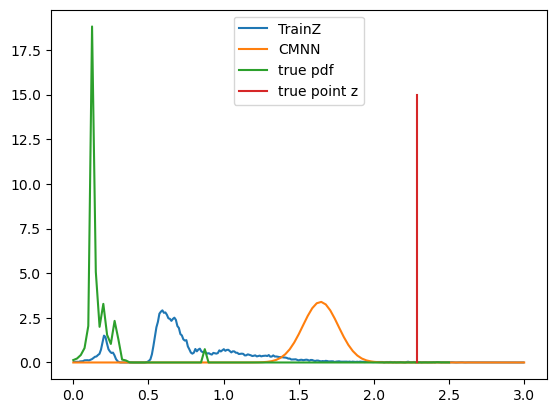

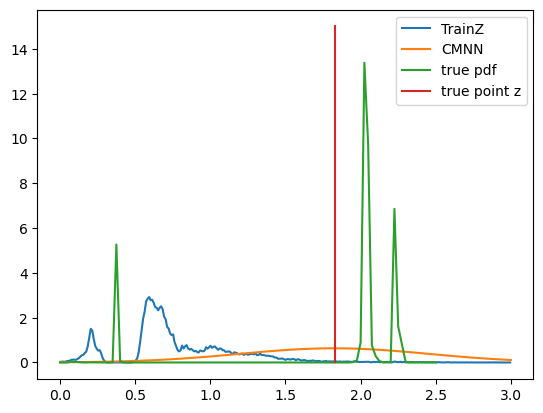

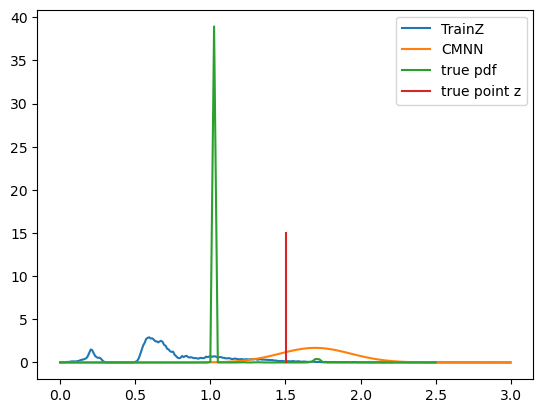

In [76]:
import h5py
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size':10})

TrainZpath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/TrainZ/DEEP2/output_estimate_TrainZ.hdf5"
TrainZfile = h5py.File(TrainZpath)
CMNNpath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/CMNN/DEEP2/output_estimate_CMNN.hdf5"
CMNNfile = h5py.File(CMNNpath)
GPzpath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/GPz/DEEP2/output_estimate_GPz.hdf5"
GPzfile = h5py.File(GPzpath)
FZBoostpath = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/FZBoost/DEEP2/output_estimate_FZBoost.hdf5"
FZBoostfile = h5py.File(FZBoostpath)
truth_pdfs = h5py.File("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsstErr_test_data_posts.hdf5")
point_zs = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error.pq")

grid = np.linspace(0, 3, 101)


for gal in range(0, 20):
    plt.plot(TrainZfile['meta']['xvals'][0], TrainZfile['data']['yvals'][gal], label = "TrainZ")
    plt.plot(grid, gaussian(CMNNfile, grid, gal), label = "CMNN")


    #plt.plot(grid, gaussian(GPzfile, grid, gal))
    #plt.plot(FZBoostfile['meta']['xvals'][0], FZBoostfile['data']['yvals'][gal])

    plt.plot(truth_pdfs['meta']['xvals'][0], truth_pdfs['data']['yvals'][gal], label = "true pdf")
    plt.plot(point_zs['redshift'][gal] * np.ones(len(truth_pdfs['meta']['xvals'][0])), np.linspace(0, 15, len(truth_pdfs['meta']['xvals'][0])), label = "true point z")

    plt.legend()
    plt.show()

In [20]:
## we'll want to compare PITs of posteriors with PITs of estimates 

<KeysViewHDF5 ['pdf_name', 'pdf_version']>